In [1]:
#Importing relevant modules etc.

import operator
import numpy as np
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.preprocessing import PolynomialFeatures

In [2]:
#TF2 Approach

#Group 1: D4

#Model subclassing - model that takes x1 and x2, constructs X and multiplies by Beta to give estimated y1 and y2

class HilbertBasis(layers.Layer):
    """Constructs Hilbert basis for given group."""

    def __init__(
        self, 
        group, 
        output_dim,
        input_dim,
        batch_size,
        name="hilbertbasis",
        **kwargs
    ):
        super(HilbertBasis, self).__init__(name=name, **kwargs)
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.group = group
        self.batch_size = batch_size
        
    def call(self, inputs):
        #inputs = [x_1,...,x_(input_dim)] for each example
        x = inputs
        if self.group==1:
            basis_elem_1 = tf.math.square(tf.math.square(x[:,0]))-6*tf.math.square(x[:,0])*tf.math.square(x[:,1])+tf.math.square(x[:,1])
            basis_elem_2 = tf.math.add(tf.math.square(x[:,0]),tf.math.square(x[:,1]))
            hilbert_basis = tf.stack([basis_elem_1,basis_elem_2],axis=1)
        #hilbert_basis = [pi_1,pi_2,...,pi_r] for each example
        return hilbert_basis
    
    
class FundEquivariants(layers.Layer):
    
    """Constructs fundamental equivariants for given group."""
    def __init__(
        self, 
        group, 
        output_dim,
        input_dim,
        batch_size,
        name="fundamentalequivariants",
        **kwargs
    ):
        super(FundEquivariants, self).__init__(name=name, **kwargs)
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.group = group
        self.batch_size = batch_size

    def call(self, inputs):
        x = inputs
        if self.group==1:
            equiv_elem_1 = x
            equiv_elem_2 = tf.stack([tf.math.pow(x[:,0],3)-3*tf.math.multiply(x[:,0],tf.math.pow(x[:,1],2)),
                                    -tf.math.pow(x[:,1],3)-3*tf.math.multiply(x[:,1],tf.math.pow(x[:,0],2))],
                                    axis=1)
            fund_equivariants = tf.stack([equiv_elem_1,equiv_elem_2],axis=1)
        return fund_equivariants
                    

class C1RealMLPApproximation(layers.Layer):
    """Approximation of C1 real function that ransforms x into y by MLP."""

    def __init__(
        self, 
        group, 
        output_dim,
        input_dim,
        hilbert_basis_dim,
        fund_equivariants_dim,
        batch_size,
        name="c1realapprox",
        **kwargs
    ):
        super(C1RealMLPApproximation, self).__init__(name=name, **kwargs)
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.hilbert_basis_dim = hilbert_basis_dim
        self.fund_equivariants_dim = fund_equivariants_dim
        self.group = group
        self.batch_size = batch_size
        self.dense32 = layers.Dense(units=64, activation='elu')
        self.dense16 = layers.Dense(units=32, activation='elu')
        self.dense8 = layers.Dense(units=8, activation='elu')
        self.dense_final = layers.Dense(units=1, activation='elu')

    def call(self, inputs):
        #inputs = [pi_1,...,pi_r] for each example
        #print('inputs',inputs)
        out_1 = self.dense32(inputs)
        #print('out_1',out_1)
        out_2 = self.dense16(out_1)
        #print('out_2',out_2)
        out_4 = self.dense8(out_2)
        #print('out_4',out_4)
        func_j = self.dense_final(out_4)
        #print('func_j',func_j)
#         if (self.dense_final.bias==0):
#             print('bias zero')
#         else:
#             print('bias not zero')
        return func_j

                         
class GroupEquivariantC1MLPApproximation(tf.keras.Model):
    """Applies the polynomial transformation and approximates Y forming an end-to-end model for training."""

    def __init__(
        self, 
        group, 
        output_dim,
        input_dim,
        hilbert_basis_dim,
        fund_equivariants_dim,
        batch_size,
        no_of_funcs,
        name="gec1mlpa",
        **kwargs
    ):
        super(GroupEquivariantC1MLPApproximation, self).__init__(name=name, **kwargs)
        self.group = group
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.hilbert_basis_dim = hilbert_basis_dim
        self.fund_equivariants_dim = fund_equivariants_dim
        self.batch_size = batch_size
        self.no_of_funcs = no_of_funcs
        self.hilbertbasis = HilbertBasis(group=group, output_dim=output_dim, input_dim=input_dim,
                                         batch_size=batch_size)
        self.fundequivariants = FundEquivariants(group=group, output_dim=output_dim, input_dim=input_dim,
                                                 batch_size=batch_size)
        self.c1realmlpapprox = C1RealMLPApproximation(group=group, output_dim=output_dim, input_dim=input_dim,
                                             batch_size=batch_size,
                                             hilbert_basis_dim=hilbert_basis_dim,
                                            fund_equivariants_dim=fund_equivariants_dim)
            
    def call(self, inputs):
        #inputs = [x_1,...,x_n] for each example
        x = inputs
        
        #Obtain Hilbert basis (shape (batch_size,r))
        hilbert_basis = self.hilbertbasis(x)
        #print("hilbert_basis",hilbert_basis)
        
        #Obtain fundamental equivariants (shape (batch_size,s,fund_equiv_dim))
        fund_equivariants = self.fundequivariants(x)
        #print("fund_equivariants",fund_equivariants)
        
        #Predict y
        y_pred = tf.zeros([self.batch_size,self.fund_equivariants_dim])
        for j in range(0,self.no_of_funcs):
            #Obtain MLP approximation for all C1 real functions (func_j shape is (batch_size,1))
            func_j = self.c1realmlpapprox(hilbert_basis)
            #print("func_j",func_j)
            
            #Multiply by fundamental equivariant (output_j shape is (batch_size,fund_equivariants_dim)
            #or (batch_size,output_dim)
            output_j = tf.math.multiply(func_j,fund_equivariants[:,j,:])
            
            #Add to running total (y_pred shape is (batch_size,fund_equivariants_dim))
            y_pred = tf.math.add(y_pred,output_j)
            
        #Add loss
        #loss = tf.math.reduce_sum(y_pred-y,axis=1)
        #loss = tf.math.multiply(tf.pow(loss,2),1/self.fund_equivariants_dim)
        #self.add_loss(loss/self.batch_size)
        
        return y_pred

In [220]:
#Training loop
#Variable parameters
n = 3200
input_dim = 2
output_dim = 2
batch_size = 32
group = 1

#Parameters fixed by choice of group
hilbert_basis_dim = 2
fund_equivariants_dim = 2
no_of_funcs = 2

#Model
model = GroupEquivariantC1MLPApproximation(group = group, output_dim = output_dim,
                                                input_dim = input_dim, 
                                                hilbert_basis_dim = hilbert_basis_dim,
                                                fund_equivariants_dim = fund_equivariants_dim,
                                                batch_size = batch_size,
                                                no_of_funcs = no_of_funcs)

#Instantiate an optimizer
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')

#Define a loss function
# def loss_fn(y_true, y_pred, batch_size, fund_equivariants_dim):
#         loss = tf.math.reduce_sum(y_pred-y_true,axis=1)
#         loss = tf.math.multiply(tf.pow(loss,2),1/fund_equivariants_dim)
#         return loss/batch_size

#Define loss object
loss_object = tf.keras.losses.MeanSquaredError()

#Degine loss function
def loss_fn(y_true, y_pred):
    if y_true.shape!=y_pred.shape:
        print('ERROR')
    return loss_object(y_true=y_true, y_pred=y_pred)

#Prepare the metrics.
train_acc_metric = tf.keras.metrics.MeanAbsoluteError()
val_acc_metric = tf.keras.metrics.MeanAbsoluteError()
test_acc_metric = tf.keras.metrics.MeanAbsoluteError()

#Prepare training dataset
x_train = np.random.uniform(low=-6,high=6,size=(n,2))
g = x_train[:,0]**2+x_train[:,1]**2
y_train = np.multiply(np.stack((g,g),axis=-1),x_train)

#Reserve samples for validation
n_2 = int(-n/2)
x_val = x_train[:,n_2:]
y_val = y_train[:,n_2:]
x_train = x_train[:,:-n_2]
y_train = y_train[:,:-n_2]

#Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))
train_dataset = train_dataset.shuffle(n, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

#Prepare the validation datasest
val_dataset = tf.data.Dataset.from_tensor_slices((x_val.astype(np.float32), y_val.astype(np.float32)))
val_dataset = val_dataset.batch(batch_size)

import time

epochs = 1
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_true=y_batch_train, y_pred=logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        #Update training metric
        train_acc_metric.update_state(y_batch_train, logits)

        # Log every 10 batches.
        if step % 32 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
            
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))
    
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
inputs tf.Tensor(
[[-6.78307563e-02  5.15899658e-01]
 [-1.17169579e+02  2.84291840e+01]
 [-1.20392688e+03  4.24903336e+01]
 [-4.22988770e+03  5.95438690e+01]
 [-4.94702005e+00  4.41055584e+00]
 [-2.79157446e+03  4.69728050e+01]
 [-3.39583496e+02  2.27364521e+01]
 [-1.42864670e+02  2.13849297e+01]
 [-1.37895300e+03  3.30377846e+01]
 [-2.57254810e+03  4.55644226e+01]
 [ 2.92412930e+01  6.72403908e+00]
 [-3.77262231e+03  5.66840782e+01]
 [-1.83357959e+03  4.29058456e+01]
 [-2.20882544e+03  4.85070267e+01]
 [-5.19242371e+02  2.05475197e+01]
 [-1.24945862e+03  3.16017799e+01]
 [-4.43176794e+00  2.19903708e+00]
 [-4.40012256e+03  5.99876633e+01]
 [-2.36637535e+01  1.65281467e+01]
 [-1.05862964e+03  3.43354912e+01]
 [-6.57576294e+01  3.09638672e+01]
 [ 1.40605984e+01  5.54332972e+00]
 [-1.12221176e+02  9.81197929e+00]
 [-1.36053267e+01  3.48136997e+00]
 [-2.37611816e+03  4.36107292e+01]
 [-4.58211899e+01  2.06517677e+01]
 [-1.20627637e+03  3.39939499e+01]
 [ 2.19913055e+02  

inputs tf.Tensor(
[[-4.9926907e-02  4.7167045e-01]
 [-3.4495944e+02  1.8952332e+01]
 [-2.2513303e+03  4.2099594e+01]
 [-6.5632007e+02  3.6266453e+01]
 [-8.2998517e+02  3.9782036e+01]
 [-1.9071534e+03  4.8223110e+01]
 [-3.1028589e+02  1.9372309e+01]
 [ 5.9883716e+02  2.8575769e+01]
 [-1.2718507e+01  3.5494995e+00]
 [ 1.8406194e+02  1.8857103e+01]
 [-2.9004292e+01  5.7330341e+00]
 [-1.7059320e+02  1.1750992e+01]
 [-4.9517494e+01  1.4325308e+01]
 [ 5.2779794e-02  1.0283092e+01]
 [-1.3728489e+01  1.9354397e+01]
 [-3.8733894e+03  5.6445290e+01]
 [-6.4857819e+02  3.2251442e+01]
 [-4.2396400e+01  1.5047284e+01]
 [ 9.9158997e+01  1.8979782e+01]
 [-1.5489807e+02  4.1236820e+01]
 [-6.0897736e+02  3.1142960e+01]
 [-4.9160007e+02  2.2486946e+01]
 [-2.6632099e+00  2.8720020e+01]
 [-1.1639130e+01  3.4544916e+00]
 [-7.8604324e+01  8.0520086e+00]
 [ 3.2824402e+00  3.7427917e+00]
 [ 1.6088435e+02  1.5878004e+01]
 [-5.1958521e+03  6.4118698e+01]
 [ 3.5041144e+02  3.8405052e+01]
 [-1.5096628e+02  3.15398

inputs tf.Tensor(
[[-7.74817749e+02  2.81884880e+01]
 [-3.67086011e+03  5.81519394e+01]
 [-2.88806372e+03  4.77280655e+01]
 [-5.10504570e+01  8.17637253e+00]
 [-2.75562458e+01  3.17412949e+01]
 [-2.63535370e+02  1.74016838e+01]
 [-3.48175201e+02  2.39223328e+01]
 [-1.17751001e+03  3.23702965e+01]
 [-3.07273132e+02  2.90111046e+01]
 [-1.27954114e+03  4.16187515e+01]
 [-3.56733325e+03  5.31777954e+01]
 [-4.91808167e+02  1.98270016e+01]
 [-4.01829529e+01  1.28464308e+01]
 [ 2.27021217e+00  2.41195240e+01]
 [-2.66563525e+03  4.85522003e+01]
 [ 3.74047424e+02  1.93406239e+01]
 [ 1.68593252e+00  1.68693912e+00]
 [-1.49738879e+03  3.76282463e+01]
 [-3.21679565e+02  1.86677017e+01]
 [-1.01941284e+02  1.03494911e+01]
 [-1.17844226e+03  3.75783195e+01]
 [ 1.33539383e+02  1.17575359e+01]
 [-2.98474146e+03  5.32024078e+01]
 [ 6.36902695e+01  7.99253416e+00]
 [-1.66955429e+02  1.18805161e+01]
 [-2.65293945e+03  5.10867157e+01]
 [-3.23437775e+02  1.70510902e+01]
 [-4.35716943e+03  6.13589630e+01]
 [

inputs tf.Tensor(
[[-1.10007019e+03  3.03974800e+01]
 [ 9.97263336e+00  2.21996765e+01]
 [-1.07954918e+02  1.94533195e+01]
 [-1.05464333e+02  3.76401825e+01]
 [ 1.16912422e+02  1.45406036e+01]
 [ 3.28097677e+00  5.10689402e+00]
 [ 1.35006819e+01  1.61734638e+01]
 [-4.45853668e+02  2.23221989e+01]
 [-2.86062012e+02  2.74419861e+01]
 [-4.32189648e+03  6.06623230e+01]
 [ 1.31471512e+02  1.28245125e+01]
 [-3.67917366e+01  5.77404737e+00]
 [-2.36913513e+02  1.38652458e+01]
 [-1.79092083e+01  1.09691982e+01]
 [ 3.07947483e+01  9.58179188e+00]
 [ 7.96133362e+02  2.82632694e+01]
 [ 1.16210144e+02  2.70359650e+01]
 [-1.97291245e+02  2.02112865e+01]
 [ 7.48668442e+01  8.75520229e+00]
 [-8.86211472e+01  1.22184639e+01]
 [-2.94277148e+03  5.42731018e+01]
 [-1.23043831e+02  1.41141405e+01]
 [-3.73429632e+00  2.40757990e+00]
 [-1.53768005e+02  2.33563690e+01]
 [ 9.29046448e+02  3.13210545e+01]
 [-1.04840039e+03  3.33812866e+01]
 [-4.34814111e+03  5.88747635e+01]
 [-7.16622162e+01  3.52444992e+01]
 [

inputs tf.Tensor(
[[-1.16154648e+02  1.02469740e+01]
 [-1.91957300e+03  4.71644440e+01]
 [ 3.51378212e+01  5.97552109e+00]
 [-3.44711609e+02  2.67195148e+01]
 [-5.00019318e+02  2.14026127e+01]
 [ 8.48676682e+01  2.13399982e+01]
 [-6.56112823e+01  8.84564590e+00]
 [-5.17207870e+01  9.71318054e+00]
 [-3.77041245e+01  1.64973602e+01]
 [-3.25269043e+03  5.57012215e+01]
 [-8.96137390e+02  3.30240860e+01]
 [ 2.37374649e+02  3.07823868e+01]
 [-8.58219719e+00  1.99247360e+01]
 [-6.56400681e+01  9.02613258e+00]
 [-3.11302734e+02  2.00012283e+01]
 [-2.42999939e+02  2.87648735e+01]
 [-2.76846973e+03  4.72043228e+01]
 [-5.07751465e+01  2.61438503e+01]
 [-1.95853138e+01  1.14732323e+01]
 [-3.42133850e+02  3.45058556e+01]
 [ 1.61385178e+02  2.47999668e+01]
 [ 1.16181351e+02  1.09246788e+01]
 [ 1.75410595e+01  2.17306385e+01]
 [-1.07042557e+02  2.26848431e+01]
 [-1.98243433e+03  3.98074417e+01]
 [-2.63990234e+03  4.68278656e+01]
 [-6.81474609e+02  2.38216095e+01]
 [-2.51533057e+03  4.80818100e+01]
 [

inputs tf.Tensor(
[[-4.3553943e+02  2.6072235e+01]
 [-6.9270990e+02  3.9049576e+01]
 [-9.1050591e+01  1.6353596e+01]
 [-1.3389996e+02  3.0834110e+01]
 [ 1.8101347e+01  1.9749735e+01]
 [-1.8083419e+03  3.7730560e+01]
 [-2.0723425e+03  4.1436176e+01]
 [ 6.0819305e+01  7.8007116e+00]
 [-3.0603014e+01  9.2984600e+00]
 [-1.2464806e+03  3.2410057e+01]
 [ 2.1621180e+01  1.7541843e+01]
 [-8.2855762e+02  4.4639465e+01]
 [-6.2138218e+01  1.4718425e+01]
 [-4.9257085e+03  6.3163063e+01]
 [ 2.2648909e+02  1.5176586e+01]
 [-2.0219094e+03  3.9896965e+01]
 [-3.0940352e+03  4.9436363e+01]
 [-2.0067207e+01  4.3019991e+00]
 [-4.1499971e+03  5.7697575e+01]
 [-1.4282778e+03  3.5615204e+01]
 [-2.7368863e+00  2.3934169e+00]
 [ 2.8463654e+02  1.7150656e+01]
 [-6.5393457e+02  2.8315849e+01]
 [ 2.9611804e-02  2.3945510e-01]
 [-3.6571881e+02  2.0637932e+01]
 [-9.3868262e+02  3.1643950e+01]
 [-4.0978672e+03  5.6899242e+01]
 [ 1.7700630e-01  3.3334992e+00]
 [-6.2439919e+01  8.5754299e+00]
 [-4.4101007e+02  1.87583

inputs tf.Tensor(
[[-5.46345947e+02  3.38072968e+01]
 [-2.86906274e+03  5.00199814e+01]
 [-6.14932922e+02  2.26900616e+01]
 [-2.36885571e+03  4.44211044e+01]
 [-3.01822852e+03  5.16676407e+01]
 [-1.51662854e+03  4.16632957e+01]
 [-1.00199945e+03  2.88926277e+01]
 [-7.04124207e+02  2.87168255e+01]
 [-1.30989001e+03  3.74855461e+01]
 [-7.71648636e+01  2.58388329e+01]
 [-3.12696667e+01  1.30173645e+01]
 [-3.55161157e+03  5.29116898e+01]
 [ 1.21900040e+02  3.02137623e+01]
 [-5.86480591e+02  2.49803028e+01]
 [-1.83500626e+02  2.41681061e+01]
 [-3.89237085e+03  5.52468262e+01]
 [ 3.05682354e+01  3.28053665e+01]
 [-1.13517733e+01  3.21697569e+00]
 [-3.40592041e+01  7.84146261e+00]
 [-6.64138794e-01  2.82762432e+01]
 [-1.15876892e+03  3.06204643e+01]
 [ 2.27443237e+01  3.11412067e+01]
 [ 3.39192566e+02  2.21184273e+01]
 [-1.02987830e+03  3.78379288e+01]
 [-2.85517578e+02  1.68323059e+01]
 [ 2.91473755e+02  2.80337105e+01]
 [ 2.46709595e+01  6.53770065e+00]
 [-7.21798584e+02  2.73606834e+01]
 [

inputs tf.Tensor(
[[-5.7788647e+02  2.6838135e+01]
 [ 4.8472695e+00  2.4564540e+00]
 [-1.1844331e+03  3.0601246e+01]
 [ 8.7507164e-01  1.7294827e+00]
 [-2.7757358e+02  2.9308788e+01]
 [-6.5423531e+01  1.8216644e+01]
 [ 7.8632355e-02  2.2449145e+00]
 [-1.0549111e+03  3.2169022e+01]
 [-1.0200621e+02  1.2875754e+01]
 [-6.2946224e-01  1.5833924e+00]
 [-1.3677106e+02  1.0617994e+01]
 [ 5.1379036e+01  1.3528890e+01]
 [-1.1648813e+00  1.3665550e+00]
 [-9.9401544e+02  2.8367517e+01]
 [-1.2955513e+01  2.4019804e+01]
 [-1.8030275e+02  2.2402737e+01]
 [-1.2320715e+03  3.1734772e+01]
 [-2.4082058e+03  4.6464752e+01]
 [-9.8441601e+00  2.6671883e+01]
 [-4.8452290e+01  6.7109032e+00]
 [-1.0370814e+02  1.3750268e+01]
 [-1.6277124e+02  3.2078045e+01]
 [-8.3493903e-02  5.4679012e-01]
 [-7.6409332e+02  2.5783463e+01]
 [-8.3985878e+01  8.3059549e+00]
 [-7.2430133e+02  2.6296387e+01]
 [ 1.9588562e+00  3.8531051e+00]
 [-1.3101901e+03  3.2192951e+01]
 [-4.1210575e+01  1.2064032e+01]
 [-3.0141943e+02  2.84816

inputs tf.Tensor(
[[-4.2172552e+02  2.7924461e+01]
 [-1.2292625e+03  3.4758984e+01]
 [-2.6780590e+01  3.3216797e+01]
 [-1.8562762e+03  4.7508846e+01]
 [-4.7238071e+02  1.9660910e+01]
 [ 9.1743547e-01  9.1745448e-01]
 [-9.7919714e+02  3.8001553e+01]
 [-1.8705322e+02  2.0765310e+01]
 [-7.2423530e+00  3.7141562e+00]
 [-8.7924736e+01  3.0288715e+01]
 [-1.0118813e+03  3.3211697e+01]
 [-3.0970564e+01  1.7195147e+01]
 [ 2.2302116e+01  6.3684816e+00]
 [-1.4476869e+03  4.5015388e+01]
 [-9.3910846e+02  4.2220810e+01]
 [ 4.4099468e+01  7.0095844e+00]
 [-2.0073282e+02  1.3681779e+01]
 [-2.0754877e+01  1.5357016e+01]
 [-3.5186145e+03  5.3690987e+01]
 [ 5.8320980e+00  5.8376579e+00]
 [-1.6255302e+01  3.8329763e+00]
 [-4.1488462e+03  5.8289680e+01]
 [-1.1849956e+02  1.1049456e+01]
 [-3.2754382e+02  1.8413551e+01]
 [-6.4052081e+02  2.2644562e+01]
 [ 2.1361093e+02  1.7057295e+01]
 [-3.5706024e+01  5.7794380e+00]
 [ 2.0214338e+01  6.3439455e+00]
 [ 7.8963318e+02  2.8735525e+01]
 [-1.1604890e+03  3.27806

Training loss (for one batch) at step 32: 8262.1699
Seen so far: 1056 samples
inputs tf.Tensor(
[[-1.54162598e+02  1.70069923e+01]
 [-2.27513733e+02  1.45907736e+01]
 [-4.42840424e+01  3.07748852e+01]
 [-2.02753811e+01  6.56649590e+00]
 [-1.74731555e+03  4.10028839e+01]
 [-2.63507141e+02  2.00898438e+01]
 [-1.67655322e+03  3.66036530e+01]
 [-1.07955090e+03  3.92140656e+01]
 [-5.95649624e+00  2.78339815e+00]
 [-3.44028473e+01  5.51246071e+00]
 [-3.94949303e+01  5.96923256e+00]
 [-5.57094971e+02  3.80883331e+01]
 [-3.37120758e+02  1.84242744e+01]
 [-2.38416113e+03  4.48405724e+01]
 [ 4.17755524e+02  2.92539330e+01]
 [-3.26737785e+01  1.04454165e+01]
 [-3.52863745e+03  5.30299683e+01]
 [-1.69170074e+01  8.43567085e+00]
 [ 5.06590605e-01  1.23949933e+00]
 [-6.31365280e+01  2.71698360e+01]
 [ 7.48501129e+01  1.00496712e+01]
 [-1.18613550e+03  3.11926994e+01]
 [-5.00664612e+02  3.55115089e+01]
 [ 1.02457273e+00  1.13581049e+00]
 [-1.25005981e+02  4.19355469e+01]
 [-1.24382385e+02  1.03615761

inputs tf.Tensor(
[[-7.1419574e+02  3.0594538e+01]
 [ 4.8344961e-01  1.7223536e+00]
 [-1.7158909e+00  4.5188842e+00]
 [ 9.0138292e+00  6.0108514e+00]
 [-1.8231732e+03  3.8829811e+01]
 [-2.9898992e+00  2.9878027e+00]
 [-6.3699072e+02  2.6248825e+01]
 [-7.5869017e+00  2.7351031e+00]
 [-7.9826462e+01  1.5245624e+01]
 [-1.7416199e+02  2.2471987e+01]
 [ 9.3883514e+00  4.8693995e+00]
 [-2.7278746e+01  1.5937763e+01]
 [ 8.4435654e+01  9.6701956e+00]
 [-2.0777592e+01  8.3462906e+00]
 [-1.4022591e+01  6.9368348e+00]
 [-1.1175585e+03  3.8447639e+01]
 [ 1.6678754e+02  2.4665621e+01]
 [-3.7032758e+02  2.4374567e+01]
 [-4.4395039e+01  2.0240978e+01]
 [-5.4863319e+01  9.3176918e+00]
 [-2.9510977e+03  4.8197495e+01]
 [-4.2525717e+02  1.8615898e+01]
 [ 1.0598367e+03  3.2634079e+01]
 [-2.4114875e+03  4.3661606e+01]
 [-9.3374603e+02  2.9592237e+01]
 [ 7.5370092e+00  3.4408836e+00]
 [ 1.0704525e-02  3.7893569e-01]
 [-1.7455542e+03  3.8734051e+01]
 [ 1.6271882e+00  2.7800825e+00]
 [-7.4407684e+01  2.49372

inputs tf.Tensor(
[[-1.2471670e+03  3.7933987e+01]
 [-2.0508374e+03  4.0166065e+01]
 [-5.2608124e+02  2.1599854e+01]
 [ 9.1694971e+02  3.0888361e+01]
 [-1.2961609e+02  2.4403648e+01]
 [-5.5424512e+02  2.5222336e+01]
 [ 2.7280675e-02  1.6395502e-01]
 [-3.1988455e+02  2.9721046e+01]
 [-3.1073262e+03  5.0015614e+01]
 [-5.5832324e+02  2.1851284e+01]
 [ 2.6847800e+02  1.9714729e+01]
 [-1.8514545e+01  2.9551765e+01]
 [-4.9381362e+03  6.4987549e+01]
 [-1.9793785e+03  4.3721054e+01]
 [ 5.2285416e+01  8.8222952e+00]
 [-9.7620535e+00  3.9943509e+00]
 [-1.4688220e+02  1.5938159e+01]
 [-1.2821738e+03  3.6279835e+01]
 [ 3.9762915e+02  2.1194042e+01]
 [-5.7399874e+00  5.3988023e+00]
 [-2.3481820e+00  2.1414170e+00]
 [-6.0559326e+02  2.8491302e+01]
 [-9.8180027e+00  5.8090835e+00]
 [ 2.8129518e-02  7.9486006e-01]
 [-1.1503779e+03  3.0403851e+01]
 [-4.8914173e+01  6.7081413e+00]
 [ 2.5319313e+01  9.9584875e+00]
 [-5.2144800e+02  2.0630825e+01]
 [-1.2387149e+02  3.2725636e+01]
 [-1.4815464e+03  3.74404

inputs tf.Tensor(
[[-2.6869073e+00  1.9057970e+00]
 [-1.4749513e+02  2.2762882e+01]
 [-2.8616592e+02  1.6171751e+01]
 [-4.0804573e+01  9.8779192e+00]
 [-1.3933011e+02  2.9464222e+01]
 [ 2.1773351e+02  1.9008556e+01]
 [ 6.2904978e-01  8.1465614e-01]
 [-4.5824805e+02  2.3224394e+01]
 [-2.3165585e+01  1.2041651e+01]
 [ 4.6879053e+02  2.1682461e+01]
 [-1.8329884e+01  1.0426597e+01]
 [-8.5886707e+02  2.8591339e+01]
 [ 2.7711115e+00  2.3465910e+00]
 [ 2.5803168e+02  2.1508175e+01]
 [ 3.0559283e+02  1.9308058e+01]
 [-2.7612900e+02  1.5714203e+01]
 [-1.9338369e-02  3.4810984e+00]
 [-1.3666160e+03  3.6397499e+01]
 [ 8.1168258e-01  1.3123796e+00]
 [-3.2787289e+02  1.6448128e+01]
 [-2.5642651e+02  2.5037348e+01]
 [-2.5383904e+03  4.5919884e+01]
 [ 2.1170137e+02  3.7382652e+01]
 [-2.8998955e+03  5.4846004e+01]
 [-1.1908848e+03  3.0798620e+01]
 [-8.5546593e+01  1.6132660e+01]
 [-5.6165826e+02  2.9374107e+01]
 [-1.6731166e+02  1.2981215e+01]
 [ 6.0392891e+01  7.8083186e+00]
 [-9.0418872e+02  3.90262

inputs tf.Tensor(
[[-4.12940399e+02  2.56618843e+01]
 [ 1.79877182e+02  1.94497223e+01]
 [-1.27468494e+03  3.28664322e+01]
 [-1.97079126e+03  4.39400787e+01]
 [ 3.13923180e-01  3.29399705e+00]
 [-1.45982031e+03  3.60426636e+01]
 [-8.55447021e+02  2.83641834e+01]
 [-3.10180615e+03  4.99263382e+01]
 [-3.95608093e+02  1.88082352e+01]
 [-2.69113588e+00  4.07993650e+00]
 [-5.84050903e+02  2.47609272e+01]
 [-7.86951416e+02  2.56974106e+01]
 [-6.37041687e+02  2.25402679e+01]
 [ 9.81178284e-02  2.78792667e+01]
 [-1.37834597e+01  1.48664579e+01]
 [ 1.66472870e+02  2.51612740e+01]
 [-8.15171021e+02  2.89528580e+01]
 [-7.70219707e+00  2.89391947e+00]
 [-1.23167305e+01  3.51083374e+00]
 [ 1.59440870e+01  1.95311527e+01]
 [ 4.91204010e+02  2.61290932e+01]
 [-4.11687939e+03  5.68310814e+01]
 [ 4.11983204e+00  5.42518902e+00]
 [-2.24473629e+01  4.96954012e+00]
 [-6.40968262e+02  3.50605927e+01]
 [ 1.78822346e+01  1.89180355e+01]
 [-1.62981995e+02  1.21992407e+01]
 [-6.47588684e+02  3.04777851e+01]
 [

inputs tf.Tensor(
[[-1.4293063e+02  2.3161968e+01]
 [ 5.1118364e+00  2.0412785e+01]
 [-9.6967786e+02  2.7713049e+01]
 [-9.7878933e+00  3.0618113e+01]
 [-1.0841107e+02  1.6607155e+01]
 [-6.2303589e+02  2.9338745e+01]
 [-1.2729495e+02  1.5937164e+01]
 [-8.8551149e+00  5.9428139e+00]
 [-1.9291753e+03  3.9001320e+01]
 [ 6.6070910e+00  4.1694489e+00]
 [-8.4811916e+00  2.8837349e+00]
 [-2.9668875e+00  2.3592384e+00]
 [-1.0962526e+03  3.0697369e+01]
 [-1.9730156e+03  4.3589973e+01]
 [ 7.6019216e+00  1.4604838e+01]
 [-1.0063343e+00  7.0997648e+00]
 [-1.0645707e+02  1.0041711e+01]
 [-8.6427197e+02  3.2298134e+01]
 [-1.0874293e+03  4.0516518e+01]
 [-1.2031714e+03  3.1159744e+01]
 [ 2.2983665e+00  2.7406448e+01]
 [ 4.2009769e+02  3.1491566e+01]
 [ 3.6857433e+00  9.0947199e+00]
 [ 8.8955481e+02  3.1562000e+01]
 [-4.5674252e+02  3.2484257e+01]
 [-1.3587778e+03  3.7789703e+01]
 [-7.8074127e-01  1.0350150e+00]
 [ 1.2373947e+01  3.5194173e+00]
 [ 1.8086261e-01  8.1333935e-01]
 [-8.9270465e+02  3.80706

inputs tf.Tensor(
[[-2.2321025e+02  1.7033016e+01]
 [-1.3172566e+01  6.3989210e+00]
 [-3.1127915e+03  5.0243317e+01]
 [-5.4510950e+02  2.1721542e+01]
 [-2.2010986e+01  4.5993161e+00]
 [-2.7150906e+03  4.6182632e+01]
 [ 6.8785858e+01  8.3055344e+00]
 [-3.6582263e+03  5.4238823e+01]
 [ 3.8823017e+01  6.9380155e+00]
 [-2.0690190e+03  4.0697510e+01]
 [-1.6129138e+02  1.9302366e+01]
 [-8.8762262e+02  2.8726229e+01]
 [-4.2550946e+02  2.4786978e+01]
 [-1.9257866e+01  4.6029253e+00]
 [-4.0748489e+02  2.3279903e+01]
 [-7.6924030e+02  2.4881304e+01]
 [-8.7893066e+02  3.9086166e+01]
 [-2.1305695e+02  3.5210682e+01]
 [-7.2047577e+01  1.7162796e+01]
 [-3.4442577e+01  1.3141026e+01]
 [-2.8404222e+01  6.6495748e+00]
 [-2.0379318e+03  4.0104359e+01]
 [-1.1394539e+01  1.2275339e+01]
 [-1.6221211e+03  3.6564766e+01]
 [-8.1712268e+02  3.5548122e+01]
 [-1.2922285e+03  3.1925543e+01]
 [-9.2600220e+02  3.2094948e+01]
 [-4.4093747e+02  1.9237068e+01]
 [ 1.6282124e+02  1.3521634e+01]
 [ 5.5351708e-02  3.08736

inputs tf.Tensor(
[[-1.42576660e+02  2.26860924e+01]
 [-1.06521881e+02  3.34241905e+01]
 [-1.42605621e+02  2.85859127e+01]
 [-1.21016331e+01  1.14708633e+01]
 [ 3.64024849e+01  8.60066891e+00]
 [ 4.61940098e+00  7.53435040e+00]
 [ 5.72641220e+01  8.58824635e+00]
 [-2.38561916e+01  4.75608540e+00]
 [-1.50289343e+03  4.22821617e+01]
 [-2.03226392e+03  4.49231033e+01]
 [ 5.17736877e+02  2.41387730e+01]
 [ 1.22820496e+02  1.19816713e+01]
 [-7.59694443e+01  2.60055866e+01]
 [-1.36542273e+03  3.28147202e+01]
 [-1.80861047e+03  4.17846146e+01]
 [-2.84793506e+03  5.20604210e+01]
 [-1.62851200e+01  6.89791012e+00]
 [ 1.07033997e+02  1.53821049e+01]
 [-8.49019958e+02  2.82959938e+01]
 [-2.58086938e+03  4.55051498e+01]
 [-1.15477280e+02  1.25460434e+01]
 [ 2.48920441e-01  3.85973930e+01]
 [ 1.12970764e+03  3.36111755e+01]
 [-6.81612427e+02  2.32494926e+01]
 [ 8.69169617e+00  3.03857660e+00]
 [ 4.26231287e-02  1.99977726e-01]
 [-3.51143694e+00  3.40837860e+00]
 [-8.17031677e+02  3.09117546e+01]
 [

Training loss (for one batch) at step 64: 12515.4492
Seen so far: 2080 samples
inputs tf.Tensor(
[[ 1.96213951e+01  1.48167934e+01]
 [ 4.61428741e+02  2.56008415e+01]
 [-2.42005249e+03  4.46899567e+01]
 [-7.01583252e+02  3.17523346e+01]
 [ 3.22381780e-02  2.10877120e-01]
 [ 2.27505295e+02  1.56964197e+01]
 [-1.02526404e+03  2.92561646e+01]
 [-2.54409595e+03  4.70413818e+01]
 [-4.92740021e+02  3.64385300e+01]
 [ 1.06589554e+02  1.79003983e+01]
 [-1.21054431e+03  4.02927895e+01]
 [ 8.11422577e+01  2.14101562e+01]
 [-1.48022900e+01  6.68326283e+00]
 [-1.31796443e+00  1.78554535e+00]
 [-1.96805298e+02  3.55512924e+01]
 [-1.63794775e+03  3.65498238e+01]
 [-9.25415878e+01  1.63569069e+01]
 [ 1.65158112e+02  1.85819817e+01]
 [-7.62412537e+02  2.49577675e+01]
 [-1.38137756e+03  3.56400719e+01]
 [ 8.04477692e-01  1.09014444e+01]
 [-8.88915649e+02  3.37674713e+01]
 [-1.08715111e+02  1.49235535e+01]
 [-1.79801483e+02  2.35772858e+01]
 [ 2.19244904e+02  1.62313271e+01]
 [-1.50311127e+02  1.9470766

inputs tf.Tensor(
[[-1.82740158e+02  2.72971401e+01]
 [-7.38485098e-01  1.63342917e+00]
 [-5.57480652e+02  2.13008671e+01]
 [-2.75457520e+02  1.51839228e+01]
 [ 1.58892502e+02  1.54122095e+01]
 [-9.00364929e+02  2.95699921e+01]
 [-4.96532501e+02  1.99641361e+01]
 [ 2.43879028e+02  3.94966965e+01]
 [-9.19540283e+02  3.21360893e+01]
 [-1.61691723e+01  3.86985016e+00]
 [-7.27001476e+00  2.99444890e+00]
 [-9.46404343e+01  1.24442158e+01]
 [-7.45753174e+02  2.80787754e+01]
 [ 7.53537109e+02  2.78766155e+01]
 [-1.92042847e+02  1.26230421e+01]
 [ 2.97025940e+02  1.76368542e+01]
 [-1.88776343e+03  4.09791107e+01]
 [-5.27999170e+03  6.48285828e+01]
 [-1.14747021e+03  3.26623840e+01]
 [-6.76113525e+02  2.90041580e+01]
 [ 6.82535172e+01  1.29423075e+01]
 [-3.17410107e+01  7.20924902e+00]
 [ 3.55299568e+01  2.08885803e+01]
 [-1.03601288e+02  3.86818047e+01]
 [-2.12616844e+01  1.11381960e+01]
 [ 1.10291565e+02  1.16989365e+01]
 [-8.37513245e+02  2.76637611e+01]
 [-1.64345398e+01  5.49516106e+00]
 [

inputs tf.Tensor(
[[-4.3577873e+01  6.1324272e+00]
 [-2.3201761e+01  5.3334742e+00]
 [-1.0338536e+03  3.1798031e+01]
 [-3.8867790e+01  8.0516701e+00]
 [-1.0321034e+01  7.3880706e+00]
 [-1.8464635e+03  4.4180611e+01]
 [-2.5012720e+03  4.6963722e+01]
 [ 6.3920927e-01  5.7284298e+00]
 [-1.7435167e+02  1.1928497e+01]
 [-2.1922361e+03  4.3220974e+01]
 [ 6.4290337e+01  1.0666494e+01]
 [ 5.8676243e-01  3.4468021e+00]
 [-1.8103225e+03  3.9408798e+01]
 [-1.6260199e+01  4.4796443e+00]
 [-1.1667319e+03  3.5253113e+01]
 [-6.0948051e+01  1.1624106e+01]
 [-3.1614031e+03  4.9868053e+01]
 [ 2.3461685e+00  2.7760754e+01]
 [-7.8288582e+01  1.0265276e+01]
 [ 7.2304977e+01  8.7102203e+00]
 [ 3.7199695e+02  1.9287979e+01]
 [-3.5311975e+02  2.1464540e+01]
 [ 1.4989599e+01  3.0266624e+01]
 [-5.0323271e+03  6.4621971e+01]
 [-5.5388336e+02  2.1260580e+01]
 [-7.0068016e+00  3.2595989e+01]
 [-4.0172549e+02  3.1387577e+01]
 [-1.0896455e+03  3.3810040e+01]
 [ 3.1233932e+02  1.7889858e+01]
 [-1.5715842e+02  1.16968

inputs tf.Tensor(
[[-3.11148014e+01  1.21677971e+01]
 [-3.11178894e+01  5.20176792e+00]
 [-2.08959009e+03  4.61218796e+01]
 [-8.89453308e+02  3.04245300e+01]
 [ 2.01276755e+00  4.82260418e+00]
 [ 7.17775513e+02  3.45129128e+01]
 [-9.61438980e+01  9.50531101e+00]
 [-1.50117700e+03  3.64155998e+01]
 [-5.09598242e+03  6.43134613e+01]
 [ 1.20754814e+02  1.25677328e+01]
 [-1.41369739e+03  3.83930931e+01]
 [ 6.02957039e+01  1.31527920e+01]
 [-1.20075836e+01  3.43624234e+00]
 [-1.21420630e+03  3.32521744e+01]
 [-9.66317291e+01  9.05229092e+00]
 [-1.35237695e+03  3.71474915e+01]
 [-9.69267944e+02  2.92340927e+01]
 [-1.25224503e+02  1.92458744e+01]
 [-4.12530762e+03  6.00079880e+01]
 [-2.39182568e+01  2.67277679e+01]
 [ 1.58557083e+02  1.63920975e+01]
 [-2.58185913e+02  2.89021645e+01]
 [ 2.16948643e+01  5.39500904e+00]
 [ 3.86917053e+02  2.03209915e+01]
 [-3.29003868e+01  5.64373684e+00]
 [ 2.99963776e+02  3.37697601e+01]
 [-8.22872559e+02  2.80490322e+01]
 [-7.29330078e+02  2.64898186e+01]
 [

inputs tf.Tensor(
[[ 6.77352600e+01  1.27716894e+01]
 [-9.43454712e+02  4.06211662e+01]
 [-2.43262012e+03  4.42244797e+01]
 [-5.97380221e-01  1.81906772e+00]
 [-2.99026245e+03  4.87949524e+01]
 [-1.83137369e+00  6.39119482e+00]
 [ 9.72120667e+02  3.23740082e+01]
 [-5.70289429e+02  2.13980770e+01]
 [ 9.60482502e+00  9.89496136e+00]
 [ 2.80154285e+01  7.88484812e+00]
 [-2.44833893e+02  3.01348896e+01]
 [ 8.88160461e+02  2.98029995e+01]
 [ 7.09946394e+00  7.10494852e+00]
 [-3.45962549e+03  5.21426849e+01]
 [-6.39060120e+02  3.40987320e+01]
 [ 1.60435696e+01  1.62482815e+01]
 [-3.13755615e+03  4.96243668e+01]
 [ 6.99286041e+01  8.36971188e+00]
 [ 4.12466187e+02  2.32210522e+01]
 [-5.20296875e+02  2.03811455e+01]
 [-4.26259041e+01  1.25229692e+01]
 [-4.24220734e+02  3.18600006e+01]
 [-2.13514551e+03  4.22504158e+01]
 [-4.57014427e+01  6.18858433e+00]
 [-1.02180865e+03  4.64159470e+01]
 [-8.95281136e-01  1.23193169e+00]
 [ 2.14944229e+02  1.97646389e+01]
 [-4.05485962e+03  5.66020317e+01]
 [

inputs tf.Tensor(
[[-3.16716064e+02  2.00618744e+01]
 [-1.00245607e+00  2.06306815e+00]
 [-2.35131592e+02  1.39431858e+01]
 [-1.29875842e+03  3.21698570e+01]
 [ 2.71854401e+02  2.73038597e+01]
 [-3.48435181e+02  2.95372982e+01]
 [-1.35229767e+02  3.04754543e+01]
 [ 3.39605408e+02  2.05023079e+01]
 [ 1.95593826e+02  2.29411163e+01]
 [-8.69181274e+02  2.62301788e+01]
 [-8.94149658e+02  2.71275482e+01]
 [-1.03043408e+03  4.20119553e+01]
 [-2.05937195e+02  2.55423851e+01]
 [-1.35934708e+02  1.17974396e+01]
 [ 2.01570450e+02  2.58012218e+01]
 [-5.92789673e+02  2.22661991e+01]
 [-1.28623810e+02  1.35850143e+01]
 [-5.92316406e+02  2.16877861e+01]
 [-2.92396271e+02  2.01143589e+01]
 [ 3.39988342e+02  2.11943092e+01]
 [-2.59173853e+03  5.28648872e+01]
 [-1.30471240e+03  3.20859375e+01]
 [-1.89107986e+02  1.47030478e+01]
 [-1.27419266e+02  2.52025719e+01]
 [-2.99635913e+03  5.09364853e+01]
 [-3.25310498e+03  5.15760727e+01]
 [ 5.20173693e+00  5.70383549e+00]
 [-1.37188342e+03  3.80932922e+01]
 [

inputs tf.Tensor(
[[-1.06706506e+03  2.96290932e+01]
 [-1.24273975e+03  3.43122253e+01]
 [-6.35063721e+02  2.71708794e+01]
 [ 9.37233093e+02  3.18530407e+01]
 [-2.79652979e+03  5.43504944e+01]
 [-5.62793579e+02  3.01262951e+01]
 [-2.41116898e+02  2.30814438e+01]
 [ 6.37987915e+02  2.54069347e+01]
 [ 1.06705933e+03  3.49926109e+01]
 [-9.99625778e+01  3.85384941e+01]
 [-1.31226730e+02  2.86205978e+01]
 [ 3.18901489e+02  2.30357857e+01]
 [ 2.69594453e-02  1.81498289e-01]
 [-3.22407349e+03  5.06721191e+01]
 [ 9.86225367e-01  1.14514637e+00]
 [ 1.02751196e+03  3.21412010e+01]
 [-1.07054822e+03  3.57130890e+01]
 [ 1.27202768e+01  4.59583759e+00]
 [-4.74516022e+02  2.03757477e+01]
 [-3.69265137e+01  8.88750839e+00]
 [-1.02283716e+03  4.65675201e+01]
 [-3.14950256e+02  3.25011711e+01]
 [-2.19454163e+02  2.98295708e+01]
 [ 7.38428223e+02  2.88676376e+01]
 [ 9.75338936e-01  2.45100689e+00]
 [-2.03368933e+03  4.00787125e+01]
 [-1.18764267e+02  1.42799692e+01]
 [-5.32119417e+00  2.77836514e+00]
 [

inputs tf.Tensor(
[[-6.7022171e+01  8.4800682e+00]
 [ 3.9337826e-01  9.7097540e-01]
 [-3.2000503e+03  5.0944969e+01]
 [-9.4544840e+00  2.9382720e+00]
 [-4.9557907e+02  4.3174141e+01]
 [ 6.5290878e+01  8.0933390e+00]
 [ 4.9045938e+02  2.3356146e+01]
 [-5.4737812e+03  6.7006989e+01]
 [-1.9094076e+03  4.6518013e+01]
 [-4.8775650e+02  3.1583735e+01]
 [-4.1838748e+02  1.9010082e+01]
 [ 1.0054143e+01  3.2174118e+00]
 [-2.3657427e+03  4.6317467e+01]
 [-2.9810210e+03  5.1866898e+01]
 [ 4.9105147e-01  9.9990225e-01]
 [-1.1256418e+03  3.2109444e+01]
 [-5.8729840e+02  2.2896378e+01]
 [-2.1692175e+03  4.1809921e+01]
 [-4.0622336e+02  3.6024361e+01]
 [-2.9550043e+02  2.2964197e+01]
 [-8.5632812e+02  3.0416161e+01]
 [-4.2157938e+02  1.8331816e+01]
 [-8.3880334e+02  2.6176069e+01]
 [-6.2200794e+00  5.6814265e+00]
 [ 2.0253798e-02  2.2591479e-02]
 [-5.2459259e+01  7.1590691e+00]
 [-1.2242238e+03  3.1731239e+01]
 [-1.6475984e+03  3.9685440e+01]
 [-1.5083523e+03  4.8266670e+01]
 [ 1.6182512e+02  1.45954

inputs tf.Tensor(
[[-1.07638454e+00  1.00789404e+01]
 [-2.54872604e+02  1.43064156e+01]
 [-1.48854889e+02  2.14143925e+01]
 [-3.12200226e+02  1.97492809e+01]
 [-4.76029633e+02  3.88184280e+01]
 [-1.08272896e+02  9.75958824e+00]
 [-1.78312952e+03  5.01540489e+01]
 [ 2.05137665e+02  3.45567513e+01]
 [ 3.00110388e+00  9.81546974e+00]
 [-2.70281391e+01  8.53112698e+00]
 [-2.59698975e+02  2.80899830e+01]
 [-1.95964775e+01  1.01114769e+01]
 [ 4.43292952e+00  5.62239027e+00]
 [-2.92001465e+03  4.79517021e+01]
 [-4.24143066e+02  2.51302090e+01]
 [ 2.51456439e-01  1.10546017e+00]
 [-3.57174103e+02  1.69377975e+01]
 [ 2.65323669e+02  1.66054382e+01]
 [-6.62035339e+02  2.40898418e+01]
 [ 2.63125591e+01  5.77061701e+00]
 [-1.36908813e+03  4.01089287e+01]
 [-2.29227707e+02  1.45981388e+01]
 [-2.53196167e+03  4.58570175e+01]
 [ 8.77487427e+02  3.74567413e+01]
 [ 9.59826050e+01  9.83449268e+00]
 [ 5.22596497e+02  2.93382282e+01]
 [-2.96254150e+03  5.44613838e+01]
 [-9.22366714e+01  1.12367830e+01]
 [

inputs tf.Tensor(
[[ 9.9700470e+00  5.7641640e+00]
 [ 1.6719221e+01  1.0713422e+01]
 [-6.4990192e+02  4.2850227e+01]
 [-1.5933379e+02  1.2156651e+01]
 [-1.3386986e+03  4.4348961e+01]
 [-3.0646555e+02  1.7044825e+01]
 [-2.8943111e+01  1.9357208e+01]
 [-8.0501196e+02  3.8244869e+01]
 [-7.2161548e+02  3.1694359e+01]
 [-4.5821190e+01  2.0651768e+01]
 [-1.8562762e+03  4.7508846e+01]
 [-2.0524098e+02  2.2967583e+01]
 [-2.4867865e+02  2.2003160e+01]
 [-9.7687427e+02  2.7928223e+01]
 [-1.1639130e+01  3.4544916e+00]
 [ 3.1831091e+02  1.7901510e+01]
 [-9.2233569e+02  3.7585106e+01]
 [-5.7790314e+01  8.6348219e+00]
 [-3.3308052e+01  1.2721985e+01]
 [-9.2891441e+01  2.3031492e+01]
 [-4.7393979e+02  2.1773941e+01]
 [-1.0304341e+03  4.2011955e+01]
 [-2.8801010e+01  5.7545185e+00]
 [-1.3952521e+03  3.3663540e+01]
 [-4.5833258e+02  2.7181179e+01]
 [-6.8818042e+02  3.9284508e+01]
 [-5.9902321e+01  2.7394228e+01]
 [-2.3503139e+01  4.5361366e+00]
 [-4.7670496e+02  2.7729925e+01]
 [-2.7419421e+02  1.54088

inputs tf.Tensor(
[[-1.80828690e+02  1.71651859e+01]
 [-4.37428955e+03  5.85747986e+01]
 [-6.33185387e+00  5.41735744e+00]
 [-7.47932673e+00  6.87856007e+00]
 [-2.12658887e+03  4.37230301e+01]
 [ 2.44435425e+02  1.89166031e+01]
 [-1.95853138e+01  1.14732323e+01]
 [-5.78123926e+03  6.81611633e+01]
 [-4.24143066e+02  2.51302090e+01]
 [-5.84050903e+02  2.47609272e+01]
 [-6.13005018e+00  2.50494385e+00]
 [-1.40225906e+01  6.93683481e+00]
 [ 8.44844055e+00  8.46422005e+00]
 [ 1.82265389e+00  1.35090530e+00]
 [-1.35432625e+01  2.32151375e+01]
 [ 6.16686344e+00  5.66820097e+00]
 [-1.18443311e+03  3.06012459e+01]
 [-6.87437286e+01  2.35198135e+01]
 [ 3.95797462e+01  1.37622509e+01]
 [ 1.73645306e+01  4.17658091e+00]
 [-2.20109863e+01  4.59931612e+00]
 [ 4.39582348e+00  2.09727287e+00]
 [ 6.32315796e+02  3.11987667e+01]
 [-1.08742932e+03  4.05165176e+01]
 [ 7.65063858e-04  2.39761192e-02]
 [-1.06504078e+01  1.26908398e+01]
 [-9.26002197e+02  3.20949478e+01]
 [-6.96605103e+02  2.52065735e+01]
 [

inputs tf.Tensor(
[[-7.5234051e+00  2.1923721e+01]
 [ 1.9279573e+01  4.8378124e+00]
 [-2.9898992e+00  2.9878027e+00]
 [ 4.7295395e+02  2.3034645e+01]
 [ 5.7806171e+02  2.4853794e+01]
 [-1.5312740e+03  3.4739460e+01]
 [-5.3354630e+01  7.3347607e+00]
 [-6.5423531e+01  1.8216644e+01]
 [-4.6894482e+02  2.7985159e+01]
 [-5.6791064e+02  2.6044540e+01]
 [-4.5641687e+02  3.0600885e+01]
 [ 4.1644875e+01  7.2912955e+00]
 [-7.8438434e+02  4.4924500e+01]
 [ 2.0236399e+00  2.0269785e+00]
 [-5.2274323e+02  3.0248917e+01]
 [-3.6328777e+01  7.2342634e+00]
 [-7.4104736e+02  2.7252670e+01]
 [ 1.2949466e+02  1.9828239e+01]
 [-1.8359100e+03  4.4845730e+01]
 [ 7.6559912e+02  2.8981569e+01]
 [-4.5927469e+02  2.0377562e+01]
 [-4.1853859e+01  1.0759937e+01]
 [ 7.6619098e+02  3.4233295e+01]
 [ 9.6544849e+02  3.7352127e+01]
 [-4.0978672e+03  5.6899242e+01]
 [-2.3201761e+01  5.3334742e+00]
 [-1.3122673e+02  2.8620598e+01]
 [-2.9483542e+00  1.9211531e+00]
 [-1.1290480e+03  2.9867619e+01]
 [-6.1462903e+02  3.44011

out_1 tf.Tensor(
[[ 4.3855453e+11 -1.0000000e+00  2.9979802e+10 ...  2.0994085e+10
   3.7914694e+10 -1.0000000e+00]
 [ 1.8365640e+11 -1.0000000e+00  1.2547518e+10 ...  8.7867064e+09
   1.5868527e+10 -1.0000000e+00]
 [-1.0000000e+00  1.1232679e+08 -1.0000000e+00 ... -1.0000000e+00
  -1.0000000e+00  2.9821402e+09]
 ...
 [ 2.9584772e+11 -1.0000000e+00  2.0218880e+10 ...  1.4158765e+10
   2.5570304e+10 -1.0000000e+00]
 [-1.0000000e+00  4.2135338e+08 -1.0000000e+00 ... -1.0000000e+00
  -1.0000000e+00  1.1184862e+10]
 [-1.0000000e+00  3.3189317e+09 -1.0000000e+00 ... -1.0000000e+00
  -1.0000000e+00  8.8163451e+10]], shape=(32, 64), dtype=float32)
inputs tf.Tensor(
[[-2.4486255e+03  4.5522217e+01]
 [-1.0252640e+03  2.9256165e+01]
 [ 2.1694864e+01  5.3950090e+00]
 [-3.2661247e+00  7.1290560e+00]
 [-4.8452290e+01  6.7109032e+00]
 [-3.7024814e+03  5.3939735e+01]
 [ 3.6224570e+00  5.9570003e+00]
 [-2.3685308e+00  3.1829963e+00]
 [ 5.1773688e+02  2.4138773e+01]
 [ 1.6146652e+02  2.7657116e+01]
 [-

inputs tf.Tensor(
[[-1.05901135e+03  2.90028515e+01]
 [-2.96983911e+03  4.82990227e+01]
 [-6.18757534e+00  2.85276031e+00]
 [-1.20392688e+03  4.24903336e+01]
 [-3.98587799e+02  3.62264366e+01]
 [ 5.62315083e+00  5.71451807e+00]
 [-1.17566541e+03  3.35317917e+01]
 [-4.14999707e+03  5.76975746e+01]
 [-1.42930634e+02  2.31619682e+01]
 [-1.28940552e+02  1.85772095e+01]
 [-1.36795459e+03  3.71090088e+01]
 [-1.51616736e+03  3.84669800e+01]
 [-2.33977509e+00  1.35863085e+01]
 [-6.81612427e+02  2.32494926e+01]
 [-3.15084656e+02  1.67719612e+01]
 [-1.09636609e+03  3.15504875e+01]
 [-2.39182568e+01  2.67277679e+01]
 [-4.26837036e+02  1.84675865e+01]
 [-9.10505905e+01  1.63535957e+01]
 [ 3.48185158e+00  2.59067955e+01]
 [-4.21222754e+03  5.78154106e+01]
 [ 1.30017281e+00  1.96780891e+01]
 [ 2.00176010e+01  2.00181999e+01]
 [ 1.35051849e+02  1.55497131e+01]
 [ 6.78587769e+02  3.00526428e+01]
 [-1.04050586e+03  3.51679230e+01]
 [ 3.39192566e+02  2.21184273e+01]
 [-1.07638454e+00  1.00789404e+01]
 [

inputs tf.Tensor(
[[-1.70001184e+03  3.71266479e+01]
 [-2.15100169e+00  1.61294997e+00]
 [-7.86158203e+02  3.67570877e+01]
 [ 7.92246580e-01  9.50556457e-01]
 [-3.28839233e+02  1.63120518e+01]
 [-8.13161499e+02  3.48648033e+01]
 [-4.36649933e+01  6.99314880e+00]
 [-2.42044020e+00  5.47303057e+00]
 [-2.25570874e+03  4.42454872e+01]
 [ 6.50799155e-01  2.36269140e+00]
 [-1.23043831e+02  1.41141405e+01]
 [-1.22311790e+02  1.83374195e+01]
 [-1.77881012e+02  1.57220316e+01]
 [-2.84042225e+01  6.64957476e+00]
 [ 6.92309448e+02  2.90754032e+01]
 [ 8.62743988e+01  1.24504671e+01]
 [-2.99026245e+03  4.87949524e+01]
 [ 1.37883194e+02  1.51172342e+01]
 [ 2.34312988e+02  2.06292248e+01]
 [ 8.15232277e+00  9.17680740e+00]
 [ 4.04241676e+01  6.36228180e+00]
 [ 1.63643322e+01  4.06404448e+00]
 [-7.00965500e+00  2.66624284e+00]
 [-3.32583496e+03  5.13381729e+01]
 [ 2.01047699e+02  1.51579752e+01]
 [-4.94438446e+02  3.84490547e+01]
 [-1.23731918e+02  2.29046631e+01]
 [-3.57060242e+01  5.77943802e+00]
 [

inputs tf.Tensor(
[[-1.67521631e+03  3.79584427e+01]
 [ 2.61853266e+00  6.75550556e+00]
 [-2.81335175e+02  1.99264164e+01]
 [-3.22375488e+02  1.60812378e+01]
 [-1.30471240e+03  3.20859375e+01]
 [-3.25419974e+00  2.50752783e+00]
 [-9.61687660e+00  1.46778021e+01]
 [-1.02598892e+02  2.33246403e+01]
 [ 5.38303375e+00  2.59182110e+01]
 [ 4.89194427e+02  2.99094429e+01]
 [-1.19477820e+03  3.12562370e+01]
 [-4.19814529e+01  5.97281265e+00]
 [-2.14320532e+03  4.18175545e+01]
 [-1.75192509e+01  4.12456226e+00]
 [-7.45631409e+02  3.02280369e+01]
 [-3.37107849e+01  1.22986698e+01]
 [-6.78475418e+01  2.92957821e+01]
 [-4.72072563e+01  1.22020550e+01]
 [-2.68690729e+00  1.90579700e+00]
 [ 2.01276755e+00  4.82260418e+00]
 [-5.83867004e+02  2.93974838e+01]
 [-1.59164331e+03  4.02354584e+01]
 [-2.74013336e+02  3.28214455e+01]
 [-2.87451965e+02  1.52416229e+01]
 [ 7.25656189e+02  3.28642311e+01]
 [-5.73998737e+00  5.39880228e+00]
 [-3.59523082e+00  1.90731859e+00]
 [-1.86572449e+03  4.27885246e+01]
 [

inputs tf.Tensor(
[[ 2.3443832e+00  3.1321779e+01]
 [ 7.0994639e+00  7.1049485e+00]
 [-2.6743049e+03  4.6478485e+01]
 [-4.3529688e+02  2.7892284e+01]
 [-2.7612900e+02  1.5714203e+01]
 [-7.9550824e+02  3.8398300e+01]
 [-3.7699189e+03  5.5184471e+01]
 [-1.3526207e+02  1.4327096e+01]
 [-8.8551149e+00  5.9428139e+00]
 [ 3.2999124e+02  1.8369324e+01]
 [-4.1488462e+03  5.8289680e+01]
 [ 3.9372082e+01  3.7872955e+01]
 [-1.1861355e+03  3.1192699e+01]
 [-2.9810210e+03  5.1866898e+01]
 [-2.4005117e+00  1.4383828e+01]
 [-1.9730156e+03  4.3589973e+01]
 [ 9.5982605e+01  9.8344927e+00]
 [ 1.1438732e+02  3.1982925e+01]
 [-1.8329884e+01  1.0426597e+01]
 [ 4.5283532e-01  4.5459619e-01]
 [-1.2365867e+02  1.0532215e+01]
 [-1.7379994e+03  3.8382164e+01]
 [-4.3577873e+01  6.1324272e+00]
 [-1.1038173e+03  2.9632032e+01]
 [ 8.8678179e+00  3.6985464e+00]
 [ 1.0598367e+03  3.2634079e+01]
 [-2.2144444e+02  1.7454369e+01]
 [-2.4896649e+02  1.6728697e+01]
 [-8.5029321e+02  3.8524399e+01]
 [-2.3849001e+01  7.70316

inputs tf.Tensor(
[[-2.4489116e+03  4.8837917e+01]
 [ 5.2259650e+02  2.9338228e+01]
 [-1.0896455e+03  3.3810040e+01]
 [-8.7400026e+00  6.0662723e+00]
 [-1.8166018e+03  4.1625225e+01]
 [-1.0664407e+03  3.4126022e+01]
 [-8.7297809e+02  2.7472507e+01]
 [-2.3240681e+02  1.4522198e+01]
 [-1.3446252e+03  3.8183811e+01]
 [-3.8849182e+01  5.8979225e+00]
 [-9.9089252e+02  3.2444752e+01]
 [-2.7896820e+02  1.5857843e+01]
 [-2.7412224e-01  1.9015335e+01]
 [-3.7800366e+03  5.4959656e+01]
 [-6.5231689e+02  2.3747391e+01]
 [-4.8828747e+01  6.8762388e+00]
 [-7.4407684e+01  2.4937252e+01]
 [-2.9611698e+01  1.3907116e+01]
 [ 5.1589374e+02  2.4812994e+01]
 [-2.0754877e+01  1.5357016e+01]
 [-3.4817520e+02  2.3922333e+01]
 [-2.9248652e+03  5.0461990e+01]
 [-8.7325873e+02  2.6696350e+01]
 [ 6.9448387e+01  2.2909370e+01]
 [ 6.2199579e+02  2.9072380e+01]
 [ 1.6138518e+02  2.4799967e+01]
 [-4.7737399e+02  1.9865566e+01]
 [-2.0539200e+01  4.3036938e+00]
 [-1.6999752e+03  4.0700500e+01]
 [-3.4015045e+02  2.54322

inputs tf.Tensor(
[[ 8.42299938e+00  2.93864036e+00]
 [-2.13039600e+03  4.41290779e+01]
 [-2.08959009e+03  4.61218796e+01]
 [ 9.81178284e-02  2.78792667e+01]
 [-2.54499658e+03  4.67158928e+01]
 [ 2.90984154e+01  9.48196030e+00]
 [-2.02753811e+01  6.56649590e+00]
 [ 4.38319969e+00  2.31765032e+00]
 [ 1.70076904e+01  2.57957668e+01]
 [ 2.75604095e+01  7.36016464e+00]
 [-1.03601288e+02  3.86818047e+01]
 [-3.57174103e+02  1.69377975e+01]
 [-1.20627637e+03  3.39939499e+01]
 [-6.05593262e+02  2.84913025e+01]
 [-1.20339709e+03  3.64160309e+01]
 [-4.70039001e+02  1.93612785e+01]
 [ 9.17655762e+02  3.49625130e+01]
 [-1.62212109e+03  3.65647659e+01]
 [-1.78443497e+02  2.01104164e+01]
 [ 4.94279144e+02  3.27732811e+01]
 [-6.39060120e+02  3.40987320e+01]
 [-2.75562458e+01  3.17412949e+01]
 [-2.31070605e+03  4.70140381e+01]
 [ 3.22779655e+00  3.01375408e+01]
 [-5.62793579e+02  3.01262951e+01]
 [ 8.65795044e+02  3.55038986e+01]
 [ 6.95926208e+02  2.81795921e+01]
 [-1.99783798e+02  1.26930065e+01]
 [

inputs tf.Tensor(
[[-8.4811916e+00  2.8837349e+00]
 [-3.4471161e+02  2.6719515e+01]
 [ 4.5664856e+02  2.1929789e+01]
 [ 3.6945514e+02  1.9230379e+01]
 [-4.3350986e+03  5.8290741e+01]
 [-3.3725338e+01  2.8963930e+01]
 [ 9.6450269e+02  3.6348728e+01]
 [-2.5720132e+02  2.3523350e+01]
 [-1.0160905e+03  4.0167568e+01]
 [-1.5055314e+03  3.7070145e+01]
 [-8.0461432e+02  2.7662516e+01]
 [-3.7733765e+03  5.4423893e+01]
 [ 3.5529957e+01  2.0888580e+01]
 [-1.1648813e+00  1.3665550e+00]
 [-2.0221420e+02  2.0577684e+01]
 [-6.2255133e+02  2.6380951e+01]
 [-8.5171216e+02  2.6033592e+01]
 [-1.2746849e+03  3.2866432e+01]
 [-1.0303822e+03  3.0235088e+01]
 [ 2.0214338e+01  6.3439455e+00]
 [-2.4298777e+03  4.4699612e+01]
 [-9.4375690e+02  2.9197155e+01]
 [ 9.7669141e+02  3.2913189e+01]
 [-1.9694930e+02  1.7857706e+01]
 [-3.2997956e+00  6.5059986e+00]
 [-5.5388336e+02  2.1260580e+01]
 [-2.6529395e+03  5.1086716e+01]
 [ 4.5366030e+00  2.2227039e+00]
 [ 3.0150677e+02  2.8036406e+01]
 [-4.9626846e+03  6.27736

inputs tf.Tensor(
[[-6.8147461e+02  2.3821609e+01]
 [-4.4100629e+02  2.3913799e+01]
 [ 3.0595346e+02  1.7837206e+01]
 [-2.8990472e+02  1.8448647e+01]
 [-2.4227309e+00  1.6328290e+00]
 [-7.6934625e+02  2.5121128e+01]
 [-2.3634004e+03  5.2353184e+01]
 [ 3.1038800e+02  1.8718782e+01]
 [-8.4038971e+02  3.9373314e+01]
 [-1.1197742e+02  1.2500192e+01]
 [-8.1954272e+02  4.2584110e+01]
 [-1.8043132e+02  1.3297346e+01]
 [-2.7470723e+03  4.9477261e+01]
 [ 9.9462323e+02  3.3185036e+01]
 [-5.9786499e+02  2.8266546e+01]
 [-2.2141362e+02  2.7315235e+01]
 [-4.9257085e+03  6.3163063e+01]
 [-4.7238071e+02  1.9660910e+01]
 [-2.3872427e+02  2.1352310e+01]
 [-1.5096628e+02  3.1539879e+01]
 [-1.4880509e+03  3.4243610e+01]
 [-2.3165585e+01  1.2041651e+01]
 [ 1.8861297e+00  1.8976998e+00]
 [-1.3867429e+03  3.8416580e+01]
 [ 4.5813408e+00  4.8888707e+00]
 [ 8.7792358e+02  3.1035728e+01]
 [-9.3799141e+01  2.7306740e+01]
 [-5.8331127e+00  1.3200886e+01]
 [-1.8918976e+03  3.8899246e+01]
 [-3.7047202e+03  5.62376

inputs tf.Tensor(
[[-1.2823074e+03  3.2963169e+01]
 [ 9.6831982e+02  3.1131649e+01]
 [-1.9666384e+01  1.3314541e+01]
 [-1.1430269e+03  3.0790997e+01]
 [ 3.2090845e+02  2.3778063e+01]
 [-2.0002588e+02  1.5315445e+01]
 [-3.8800590e+00  2.2689896e+00]
 [-1.5947447e+01  9.2726479e+00]
 [-8.4266405e+00  4.6630425e+00]
 [-4.1823569e+03  5.9822323e+01]
 [ 4.8986855e+00  8.8856554e+00]
 [-2.9376935e+02  2.1212465e+01]
 [-3.6180367e+01  7.1079583e+00]
 [ 6.7240746e+01  8.3795986e+00]
 [-5.9428937e+02  3.0167847e+01]
 [-2.7915745e+03  4.6972805e+01]
 [-1.1421771e+02  1.1626325e+01]
 [ 2.7290809e+00  2.8678739e+00]
 [ 5.5225220e+01  9.0800543e+00]
 [-1.4543629e+03  3.9055103e+01]
 [-1.0864890e+03  3.7411488e+01]
 [-2.7803540e+03  5.2100506e+01]
 [-3.2406211e+00  1.9955986e+00]
 [-9.9401192e+01  1.6832125e+01]
 [-5.1720787e+01  9.7131805e+00]
 [-1.0883344e+03  2.9567543e+01]
 [-1.6726834e+02  1.8268581e+01]
 [-3.3743344e+02  1.6532242e+01]
 [ 6.2465267e+00  2.1283510e+01]
 [-1.5870505e+03  3.53700

inputs tf.Tensor(
[[ 1.12843752e-01  5.78836262e-01]
 [ 1.38222824e+02  1.34464035e+01]
 [-4.34041473e+02  2.51139793e+01]
 [-1.73031281e+02  1.52884502e+01]
 [ 1.65158112e+02  1.85819817e+01]
 [-2.98833325e+03  4.96769714e+01]
 [-1.45554419e+03  4.15435333e+01]
 [-5.18651367e+03  6.56661682e+01]
 [-1.92375885e+02  1.94491806e+01]
 [-1.31060327e+03  4.05587349e+01]
 [-1.84391602e+03  3.98816986e+01]
 [-3.55161157e+03  5.29116898e+01]
 [ 6.60296059e+00  3.20966873e+01]
 [ 3.68664368e+02  1.92872467e+01]
 [ 8.50618286e+02  2.98696995e+01]
 [-1.24716699e+03  3.79339867e+01]
 [ 3.40084595e+02  1.84420166e+01]
 [ 3.29354134e+01  8.35116196e+00]
 [-7.17161804e+02  2.45441666e+01]
 [-2.13784790e+03  4.12950363e+01]
 [ 4.12466187e+02  2.32210522e+01]
 [ 2.09647045e+01  8.01081944e+00]
 [-1.98243433e+03  3.98074417e+01]
 [-1.73693939e+02  1.19793530e+01]
 [-1.47539429e+02  3.63709679e+01]
 [-3.54227637e+03  5.27200165e+01]
 [-4.31891937e+02  3.27712631e+01]
 [-8.09905579e+02  3.60431137e+01]
 [

inputs tf.Tensor(
[[ -112.16772      17.969011 ]
 [-2645.4355       45.60355  ]
 [ -248.74251      20.993923 ]
 [-4060.2126       60.618477 ]
 [ -969.26794      29.234093 ]
 [   76.22637      19.36611  ]
 [ -109.10024      11.44803  ]
 [-1273.6263       40.217888 ]
 [-3085.2908       50.26911  ]
 [-1650.8829       36.056206 ]
 [ -965.826        28.665499 ]
 [  -21.67585      32.885197 ]
 [ -570.37604      23.98149  ]
 [ -345.02988      16.631674 ]
 [ -652.6134       25.607382 ]
 [ -311.4908       17.427141 ]
 [-1025.2682       37.28382  ]
 [   -6.4482203     5.9405594]
 [   99.159        18.979782 ]
 [-1144.3999       31.171112 ]
 [ -481.0654       23.987438 ]
 [ -249.75201      32.660324 ]
 [   77.33713      11.014304 ]
 [   15.760738     21.805544 ]
 [-2921.1616       47.909233 ]
 [-1246.4806       32.410057 ]
 [  350.41144      38.405052 ]
 [  -30.869884     17.658413 ]
 [  -48.547554      6.3775287]
 [-1210.5443       40.29279  ]
 [   14.904727     15.003775 ]
 [-1467.0729       46

inputs tf.Tensor(
[[-1.13379529e+03  3.74224968e+01]
 [-5.86136222e-01  1.99323893e+00]
 [ 4.43292952e+00  5.62239027e+00]
 [-1.32234619e+03  4.13224449e+01]
 [-6.37708759e+00  9.65430450e+00]
 [-8.81362183e+02  2.82462006e+01]
 [-3.11643994e+03  5.11258163e+01]
 [-3.11319828e+01  3.16122608e+01]
 [-2.53296005e+02  1.50977173e+01]
 [ 7.63983612e+01  1.15400352e+01]
 [ 8.81553284e+02  3.57822151e+01]
 [-2.88806372e+03  4.77280655e+01]
 [ 1.21900040e+02  3.02137623e+01]
 [-4.93013855e+02  3.25591354e+01]
 [ 3.29820801e+02  1.88326740e+01]
 [-2.96295093e+03  4.92938766e+01]
 [ 1.96530380e+02  3.55091972e+01]
 [-3.07098175e+02  1.56830854e+01]
 [-8.69181274e+02  2.62301788e+01]
 [-9.59155884e+01  3.66673126e+01]
 [-2.17230767e-02  4.51094270e-01]
 [ 1.09778491e+03  3.57049904e+01]
 [ 2.86648102e+02  1.95072479e+01]
 [-2.10154739e+02  1.87985306e+01]
 [ 3.43711586e+01  6.20312738e+00]
 [-1.65502051e+03  3.91684990e+01]
 [ 6.27242310e+02  2.53291607e+01]
 [ 1.22820496e+02  1.19816713e+01]
 [

inputs tf.Tensor(
[[ 1.1380146e+03  3.6642178e+01]
 [-4.7831790e+02  2.2084921e+01]
 [-3.4651296e+03  5.3336906e+01]
 [-1.6950944e+03  3.8092606e+01]
 [ 1.2704570e+01  1.2706385e+01]
 [-1.4667064e-03  9.5924002e-01]
 [-3.0941457e-02  1.5520940e+00]
 [ 1.4350311e+01  2.9154320e+01]
 [-1.2973020e+03  3.4514744e+01]
 [-1.7368471e+02  1.5209332e+01]
 [-1.7356293e+02  2.2397516e+01]
 [-2.5577556e+02  2.3149809e+01]
 [-9.9962578e+01  3.8538494e+01]
 [-1.5715842e+02  1.1696829e+01]
 [ 9.9255444e+02  3.1984320e+01]
 [ 3.6402485e+01  8.6006689e+00]
 [-1.0912955e+03  3.0050514e+01]
 [ 1.7262674e+01  5.0313830e+00]
 [-6.0519312e+02  3.3562077e+01]
 [-2.9668875e+00  2.3592384e+00]
 [-2.0297626e+02  1.9785561e+01]
 [-6.5642834e-01  5.4719467e+00]
 [ 5.1118364e+00  2.0412785e+01]
 [-7.6344446e+02  2.4872164e+01]
 [ 1.8101347e+01  1.9749735e+01]
 [-5.2320148e+02  2.9575392e+01]
 [-5.0576302e+01  1.0370176e+01]
 [-8.2372791e+02  2.5588829e+01]
 [ 2.5016286e+02  3.7755676e+01]
 [-2.0322639e+03  4.49231

inputs tf.Tensor(
[[ 1.1722803e+00  9.6425323e+00]
 [-2.0159479e+02  1.9657282e+01]
 [-3.1609222e+02  3.6392826e+01]
 [ 3.9762915e+02  2.1194042e+01]
 [ 4.4099468e+01  7.0095844e+00]
 [-2.3663754e+01  1.6528147e+01]
 [-3.8867790e+01  8.0516701e+00]
 [-1.9680530e+02  3.5551292e+01]
 [-8.7068311e+02  3.4954266e+01]
 [-3.5208072e+02  1.8185812e+01]
 [ 1.1678144e+02  1.0811155e+01]
 [-1.4508025e+03  3.5421345e+01]
 [-9.1478157e+01  1.8085522e+01]
 [ 1.2641047e-03  1.0080382e-02]
 [-4.6805504e+01  1.2697775e+01]
 [-6.4164795e+02  2.2688627e+01]
 [-8.5689077e+00  1.0164912e+01]
 [-4.1253076e+03  6.0007988e+01]
 [ 6.3920609e+01  1.5481757e+01]
 [-1.6640825e+03  3.6210388e+01]
 [-2.1710352e+03  4.6276604e+01]
 [-2.5180281e+03  4.8470360e+01]
 [-5.6034004e+01  2.8414835e+01]
 [-1.2795411e+03  4.1618752e+01]
 [-2.7965298e+03  5.4350494e+01]
 [ 4.5517860e+01  8.3615656e+00]
 [-2.5714756e+01  6.2273788e+00]
 [ 1.4937706e+02  1.3939420e+01]
 [ 7.5353711e+02  2.7876616e+01]
 [-3.2664182e+02  2.28353

inputs tf.Tensor(
[[ 6.9928604e+01  8.3697119e+00]
 [ 7.3890127e-02  2.8866705e-01]
 [ 1.0415226e+02  1.1171071e+01]
 [-8.9528114e-01  1.2319317e+00]
 [ 2.9702594e+02  1.7636854e+01]
 [-3.0182285e+03  5.1667641e+01]
 [ 8.5771985e+02  2.9470737e+01]
 [-3.3766102e+01  8.4334145e+00]
 [ 5.9195691e+02  3.8806572e+01]
 [ 2.7711115e+00  2.3465910e+00]
 [ 4.8736829e-01  1.1437562e+00]
 [ 1.4026100e+01  4.4372840e+00]
 [-4.0548596e+03  5.6602032e+01]
 [-2.4081433e+02  1.4347665e+01]
 [ 9.6048250e+00  9.8949614e+00]
 [ 6.7729950e+00  6.5581303e+00]
 [-3.4512520e+01  6.7254953e+00]
 [-1.2101633e+01  1.1470863e+01]
 [-1.8103225e+03  3.9408798e+01]
 [-3.5167695e+03  5.3455238e+01]
 [-5.9644440e+02  2.2198946e+01]
 [-2.9612531e+02  3.6648777e+01]
 [-1.0057851e+03  3.6719948e+01]
 [ 6.2074133e+02  3.2655239e+01]
 [-2.3513159e+02  1.3943186e+01]
 [-1.4592468e+03  3.6031151e+01]
 [-2.9647617e+02  3.5457230e+01]
 [ 3.2641265e+00  3.9495752e+00]
 [-3.4593799e+03  5.2319557e+01]
 [-8.9661194e+01  1.06462

inputs tf.Tensor(
[[ 5.53517081e-02  3.08736980e-01]
 [-1.16673193e+03  3.52531128e+01]
 [-2.81579248e+03  4.82886543e+01]
 [ 1.96514038e+02  3.50746193e+01]
 [-3.98109550e+01  8.05222321e+00]
 [-2.36885571e+03  4.44211044e+01]
 [-3.41019806e+02  3.53435593e+01]
 [-1.06396389e+00  5.94354773e+00]
 [-4.95174942e+01  1.43253078e+01]
 [ 6.36902695e+01  7.99253416e+00]
 [-1.07541916e+02  1.69443645e+01]
 [-1.50289343e+03  4.22821617e+01]
 [-9.79197144e+02  3.80015526e+01]
 [-2.54872604e+02  1.43064156e+01]
 [-9.43454712e+02  4.06211662e+01]
 [-2.62930322e+00  2.20165300e+00]
 [-3.66705859e+03  5.43387909e+01]
 [-6.40968262e+02  3.50605927e+01]
 [ 8.21476440e+02  3.70266304e+01]
 [-4.63243945e+03  6.12523689e+01]
 [ 2.12751541e+01  2.68225403e+01]
 [ 2.48920441e-01  3.85973930e+01]
 [-1.23871490e+02  3.27256355e+01]
 [ 1.59440870e+01  1.95311527e+01]
 [-2.18744488e+01  2.58782654e+01]
 [-1.03732068e+03  3.00836887e+01]
 [ 7.86323547e-02  2.24491453e+00]
 [-1.62771240e+02  3.20780449e+01]
 [

inputs tf.Tensor(
[[ 4.92103058e+02  2.53251534e+01]
 [-3.87338940e+03  5.64452896e+01]
 [-1.18487953e+02  2.51949787e+01]
 [-2.36574268e+03  4.63174667e+01]
 [-1.08092236e+03  3.03175545e+01]
 [-4.15714951e+01  1.06962852e+01]
 [ 4.10235199e+02  3.27574692e+01]
 [-6.34988342e+02  2.51010513e+01]
 [-9.54430878e-01  1.16760921e+00]
 [-3.01419434e+02  2.84816875e+01]
 [-4.41010071e+02  1.87583122e+01]
 [-2.06764278e+01  5.22567654e+00]
 [-1.08706543e+03  3.96365662e+01]
 [-4.69234085e+00  3.53156662e+01]
 [-1.10007019e+03  3.03974800e+01]
 [ 5.15381042e+02  3.18257866e+01]
 [ 6.60709095e+00  4.16944885e+00]
 [ 1.16815369e+03  3.50109863e+01]
 [-2.49179886e+02  1.44217615e+01]
 [-6.02146530e+01  1.05054493e+01]
 [ 6.87542725e+00  2.63026619e+00]
 [ 1.19616431e+03  3.45996437e+01]
 [ 4.53861618e+01  6.76589584e+00]
 [-2.41777808e+03  4.66680756e+01]
 [ 2.19244904e+02  1.62313271e+01]
 [-7.24301331e+02  2.62963867e+01]
 [-1.07509802e+03  4.33831177e+01]
 [-6.77570648e+01  1.81381607e+01]
 [

inputs tf.Tensor(
[[-1.07500305e+03  3.25555840e+01]
 [-2.57677948e+02  1.50189457e+01]
 [-1.13865288e+02  1.48970652e+01]
 [-3.81314774e+01  2.72987518e+01]
 [-1.49116383e+01  6.54740858e+00]
 [-1.61071014e+02  2.02271519e+01]
 [ 1.16210144e+02  2.70359650e+01]
 [-1.76923816e+03  4.45083199e+01]
 [-6.76113525e+02  2.90041580e+01]
 [ 2.84636536e+02  1.71506557e+01]
 [-3.81226082e+01  7.19829702e+00]
 [-2.44631299e+03  4.38424187e+01]
 [ 2.06741791e+02  2.65806618e+01]
 [-1.61291382e+02  1.93023663e+01]
 [-3.00697052e+02  1.81770782e+01]
 [-3.79835749e+00  2.11417055e+00]
 [-2.67569855e+02  3.47387581e+01]
 [-2.08213520e+01  5.48410034e+00]
 [-7.24235296e+00  3.71415615e+00]
 [-4.69117165e+01  6.32507610e+00]
 [-5.15777832e+02  2.05701599e+01]
 [-3.29045996e+03  5.50390930e+01]
 [-1.62730786e+03  3.84454498e+01]
 [-2.05498413e+03  4.58304977e+01]
 [-6.20693604e+02  2.22026825e+01]
 [-1.14448083e+03  3.05712929e+01]
 [-8.89078186e+02  3.47424889e+01]
 [-4.08732361e+02  2.57366428e+01]
 [

inputs tf.Tensor(
[[-2.63990234e+03  4.68278656e+01]
 [-1.95511987e+03  3.92591438e+01]
 [ 1.16912422e+02  1.45406036e+01]
 [-3.94956665e+01  2.52341900e+01]
 [-1.26468506e+02  2.21254921e+01]
 [-2.38669113e+02  1.95226040e+01]
 [-5.07400093e+01  6.58317184e+00]
 [-1.98523413e+03  4.12251740e+01]
 [-9.47035027e+00  3.39196539e+00]
 [-1.01260475e+02  1.51398191e+01]
 [-3.26987396e+02  2.01732483e+01]
 [-1.98424263e+01  1.40779533e+01]
 [ 8.77487427e+02  3.74567413e+01]
 [-1.04827734e+03  3.19061794e+01]
 [ 1.23231211e+01  1.49962311e+01]
 [ 9.59545135e+00  1.27860689e+01]
 [ 6.35810730e+02  3.42708588e+01]
 [-1.51512690e+01  4.07812548e+00]
 [ 2.91184937e+02  1.71701298e+01]
 [ 9.50219650e+01  1.55954456e+01]
 [-3.69229202e+01  7.48104191e+00]
 [-8.52226181e+01  1.16791992e+01]
 [-8.49019958e+02  2.82959938e+01]
 [-2.04488388e+02  3.33354187e+01]
 [-1.42400403e+03  3.61479416e+01]
 [-3.98813546e-01  1.01699698e+00]
 [ 7.88650635e+02  2.93002148e+01]
 [-7.63649170e+02  2.45945377e+01]
 [

inputs tf.Tensor(
[[-9.6143898e+01  9.5053110e+00]
 [ 1.5536333e+01  5.4828854e+00]
 [-1.9561150e+03  3.9728065e+01]
 [-8.6736084e+01  1.3940275e+01]
 [-3.3715726e+02  2.1461943e+01]
 [ 1.1618135e+02  1.0924679e+01]
 [-1.2360477e+02  1.0838830e+01]
 [-2.5796680e+03  4.5366318e+01]
 [-1.6673762e+03  3.8669277e+01]
 [-3.4919821e+02  2.7487276e+01]
 [-5.2027100e+01  7.1009178e+00]
 [ 6.3961130e-01  1.4924037e+00]
 [-5.9278967e+02  2.2266199e+01]
 [ 7.7018027e+00  1.0587940e+01]
 [ 3.4606009e+00  2.2874227e+00]
 [-7.1696063e+02  2.4297241e+01]
 [ 1.2720277e+01  4.5958376e+00]
 [-3.7066221e+03  5.4426140e+01]
 [-2.8798250e+03  4.9367878e+01]
 [-1.8385128e+03  4.1094933e+01]
 [ 1.1562332e+00  1.1421258e+00]
 [-4.2146024e+02  1.9649998e+01]
 [-9.5105690e-01  1.1328330e+00]
 [-1.0321034e+01  7.3880706e+00]
 [-1.0795509e+03  3.9214066e+01]
 [ 2.3879097e+01  2.4301249e+01]
 [-1.2961609e+02  2.4403648e+01]
 [-8.3733360e+01  1.2162291e+01]
 [-2.5213801e+03  4.4738407e+01]
 [ 4.6194010e+00  7.53435

inputs tf.Tensor(
[[-3.65718811e+02  2.06379318e+01]
 [-1.08272896e+02  9.75958824e+00]
 [-2.42005249e+03  4.46899567e+01]
 [-5.87295898e+02  2.16420670e+01]
 [ 1.05648523e+03  3.34951439e+01]
 [-7.75109253e+02  2.96039352e+01]
 [ 9.97328293e-03  9.78495628e-02]
 [-4.29778259e+02  1.95506821e+01]
 [-1.03096275e+01  3.85665512e+00]
 [-1.74354102e+03  3.91736603e+01]
 [ 3.42035651e-01  5.52233338e-01]
 [-2.14330902e+02  3.22282524e+01]
 [-3.09467438e+02  2.16573315e+01]
 [ 4.91126801e+02  2.28892479e+01]
 [-1.42827783e+03  3.56152039e+01]
 [-3.71690796e+02  2.28939991e+01]
 [-2.79822388e+01  1.42293224e+01]
 [-1.01641113e+03  4.00275345e+01]
 [ 3.20126610e+01  1.16005955e+01]
 [-5.10504570e+01  8.17637253e+00]
 [ 8.04477692e-01  1.09014444e+01]
 [-2.48597794e+02  2.26471672e+01]
 [-2.39980005e+03  4.72064934e+01]
 [-1.35229767e+02  3.04754543e+01]
 [-8.45066101e+02  3.97454147e+01]
 [-6.78307563e-02  5.15899658e-01]
 [ 1.76293793e+01  4.57856607e+00]
 [-4.65590625e+03  6.17484932e+01]
 [

inputs tf.Tensor(
[[-6.09480515e+01  1.16241064e+01]
 [-1.39608126e+01  6.65987682e+00]
 [-7.00168133e-01  9.75447297e-01]
 [-7.96796265e+01  1.29562683e+01]
 [ 2.02537980e-02  2.25914791e-02]
 [-9.35469482e+02  3.33366661e+01]
 [-1.79571021e+03  3.86583900e+01]
 [-2.83935083e+03  5.40751877e+01]
 [ 1.63343048e+01  1.83666801e+01]
 [ 2.63888288e+00  1.62841368e+00]
 [-3.66659058e+03  5.37166252e+01]
 [-1.79793201e+03  3.95726585e+01]
 [-4.54025269e+02  1.95019646e+01]
 [ 3.28442383e+01  7.16244459e+00]
 [-2.34818196e+00  2.14141703e+00]
 [ 1.34906025e+01  1.56756592e+01]
 [-2.06092396e+01  5.01611423e+00]
 [-9.42957825e+02  4.62915115e+01]
 [ 5.37987785e+01  7.37826157e+00]
 [-1.35877783e+03  3.77897034e+01]
 [-6.04694031e+02  2.50891914e+01]
 [-1.69470508e+03  3.71880798e+01]
 [-4.08045731e+01  9.87791920e+00]
 [-1.25201397e+01  5.85455132e+00]
 [-3.16716064e+02  2.00618744e+01]
 [ 6.10282166e+02  2.89058552e+01]
 [-1.41062561e+02  1.29111500e+01]
 [-9.38682617e+02  3.16439495e+01]
 [

In [3]:
import time

def training_loop_on(optimizer):
    
    #Tensors for testing optimizers
    losses = []
    grads_list = []
    
    epochs = 50
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

            # Open a GradientTape to record the operations run
            # during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as tape:

                # Run the forward pass of the layer.
                # The operations that the layer applies
                # to its inputs are going to be recorded
                # on the GradientTape.
                logits = model(x_batch_train, training=True)  # Logits for this minibatch
                #print('trainable weights',model.trainable_weights)

                # Compute the loss value for this minibatch.
                loss_value = loss_fn(y_true=y_batch_train, y_pred=logits)

            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, model.trainable_weights)
            
            #Testing optimizers
            #print(losses)
            #print(loss_value)
            losses.append(loss_value)
            #print('final',losses)
            
            #print(grads_list)
            #print(grads[-1])
            grads_list.append(grads[-1])
            #print('final',grads_list)
            
            #Debugging
    #         print("All the model variables")
    #         print(model.variables)
    #         print("Trainable variables only")
    #         print(model.trainable_variables)
    #         print("Trainable weights only")
            #print([v.name for v in model.trainable_weights])
            #print('grads:',grads) 

            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            #Update training metric
            train_acc_metric.update_state(y_batch_train, logits)

            # Log every 10 batches.
            if step % 32 == 0:
                print(
                    "Training loss (for one batch) at step %d: %.4f"
                    % (step, float(loss_value))
                )
                print("Seen so far: %s samples" % ((step + 1) * batch_size))

        # Display metrics at the end of each epoch.
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()

        # Run a validation loop at the end of each epoch.
        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val, training=False)
            # Update val metrics
            val_acc_metric.update_state(y_batch_val, val_logits)
        val_acc = val_acc_metric.result()
        val_acc_metric.reset_states()
        print("Validation acc: %.4f" % (float(val_acc),))
        print("Time taken: %.2fs" % (time.time() - start_time))
        
    losses = tf.stack(losses)
    grads_list = tf.stack(grads_list)
    return losses,grads_list

In [ ]:
#Instantiate different optimizers
optimizer_SGD = tf.keras.optimizers.SGD(
    learning_rate=0.001,
    momentum=0.0,
    nesterov=False,
    name='SGD')
optimizer_RMS = tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop")
optimizer_Adam = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam")
optimizer_Adagrad = tf.keras.optimizers.Adagrad(
    learning_rate=0.001,
    initial_accumulator_value=0.1,
    epsilon=1e-07,
    name="Adagrad")

#Lists for training
optimizer_list = [optimizer_SGD,optimizer_RMS,optimizer_Adam,optimizer_Adagrad]
optimizer_names = ['SGD','RMS','Adam','Adagrad']

#Testing optimizers
all_loss_times,all_grad_times,all_losses,all_grads = [],[],[],[]
for i in range(len(optimizer_list)):
    print("\nOptimizer used:", optimizer_names[i])
    losses,grads_list = training_loop_on(optimizer_list[i])
    all_losses.append(losses)
    all_grads.append(grads_list)

In [ ]:
#Plots to compare training on different optimizers
colours = ['b', 'c', 'y', 'r']
plots = []
epochs = 50
plot_times = [i for i in range(int(epochs*(n/batch_size)))]

#Plot graph of training time vs loss values for each optimizer
plt.figure(figsize=(14, 10))
for i in range(len(optimizer_list)):
    p, = plt.plot(plot_times,all_losses[i],color=colours[i],label=optimizer_names[i])
    plots.append(p)
plt.legend(handles=plots, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Time \(s\)')
plt.ylabel('Loss')

plt.show()

#Plot graph of training time vs gradient values for each optimizer
plt.figure(figsize=(14, 10))
for i in range(len(optimizer_list)):
    y = all_grads[i]
    p, = plt.plot(plot_times,y[:,0,0],color=colours[i],label=optimizer_names[i])
    plots.append(p)    
#plt.legend(handles=plots, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Time (batch no.)')
plt.ylabel('Grads')

plt.show()

In [166]:
#Testing loop
#Prepare testing dataset
x_test = np.random.uniform(low=-6,high=6,size=(n,2))
g = x_test[:,0]**2+x_test[:,1]**2
y_test = np.multiply(np.stack((g,g),axis=-1),x_test)

#Load testing dataset
test_dataset = tf.data.Dataset.from_tensor_slices((x_test.astype(np.float32), y_test.astype(np.float32)))
test_dataset = test_dataset.batch(batch_size)

#Run model on test data
val_logits = tf.constant([[0.,0.]])
for step,(x_batch_test, y_batch_test) in enumerate(test_dataset):
    predictions = model(x_batch_test, training=False)
    val_logits = tf.concat([val_logits,predictions],axis=0)
    # Update test metrics
    test_acc_metric.update_state(y_batch_test, predictions)
    test_acc = test_acc_metric.result()
    test_acc_metric.reset_states()
    print("Testing acc: %.4f" % (float(test_acc),))

#g .f(x)
val_logits_normal_aug = tf.multiply(tf.constant([[1.,-1.]]),val_logits)


#Prepare augmented testing dataset
val_logits_x_aug = tf.multiply(tf.constant([[1.,-1.]]),x_test)
val_logits_g = val_logits_x_aug[:,0]**2+val_logits_x_aug[:,1]**2
val_logits_y_true = np.multiply(np.stack((val_logits_g,val_logits_g),axis=-1)
                                ,val_logits_x_aug)

#Load augmented testing dataset
test_dataset = tf.data.Dataset.from_tensor_slices((val_logits_x_aug,
                                                   val_logits_y_true))
test_dataset = test_dataset.batch(batch_size)

#Run model on augmented test data
val_logits_aug_normal = tf.constant([[0.,0.]])
for step,(val_logits_x_aug, val_logits_y_true) in enumerate(test_dataset):
    predictions = model(val_logits_x_aug, training=False)
    val_logits_aug_normal = tf.concat([val_logits_aug_normal,predictions],axis=0)
    # Update test metrics
    test_acc_metric.update_state(val_logits_y_true, predictions)
    test_acc = test_acc_metric.result()
    test_acc_metric.reset_states()
    print("Testing acc: %.4f" % (float(test_acc),))

# val_logits_x = np.random.uniform(low=-6,high=6,size=(n,2))
# val_logits_g = val_logits_x[:,0]**2+val_logits_x[:,1]**2
# val_logits = np.multiply(np.stack((val_logits_g,val_logits_g),axis=-1),val_logits_x)

# #g .f(x)
# val_logits_x_normal = val_logits_x
# val_logits_g_normal = val_logits_g
# val_logits_normal = val_logits
# val_logits_normal_aug = val_logits_normal
# val_logits_normal_aug[:,1] *= -1

# #f . g(x)
# val_logits_x_normal = val_logits_x
# val_logits_x_aug = val_logits_x_normal
# val_logits_x_aug[:,1] *= -1
# val_logits_g_aug = val_logits_x_aug[:,0]**2+val_logits_x_aug[:,1]**2
# val_logits_aug_normal = np.multiply(np.stack((val_logits_g_aug,val_logits_g_aug),axis=-1)
#                                       ,val_logits_x_aug)



Testing acc: 79.0064
Testing acc: 87.9416
Testing acc: 81.2485
Testing acc: 75.7271
Testing acc: 79.1640
Testing acc: 104.8721
Testing acc: 84.9293
Testing acc: 94.9158
Testing acc: 80.4514
Testing acc: 81.5593
Testing acc: 84.5222
Testing acc: 92.7856
Testing acc: 91.9247
Testing acc: 90.8067
Testing acc: 97.9135
Testing acc: 112.2815
Testing acc: 107.2610
Testing acc: 89.3872
Testing acc: 97.9144
Testing acc: 85.1912
Testing acc: 86.9407
Testing acc: 118.0111
Testing acc: 98.3665
Testing acc: 102.4778
Testing acc: 82.7855
Testing acc: 113.8700
Testing acc: 91.8477
Testing acc: 97.1396
Testing acc: 101.8267
Testing acc: 121.0604
Testing acc: 88.9529
Testing acc: 92.4928
Testing acc: 79.9350
Testing acc: 87.5367
Testing acc: 83.6436
Testing acc: 95.8522
Testing acc: 84.2748
Testing acc: 86.1118
Testing acc: 111.6045
Testing acc: 109.8160
Testing acc: 82.2090
Testing acc: 100.6080
Testing acc: 110.0829
Testing acc: 97.3815
Testing acc: 93.0071
Testing acc: 73.5139
Testing acc: 73.9040
T

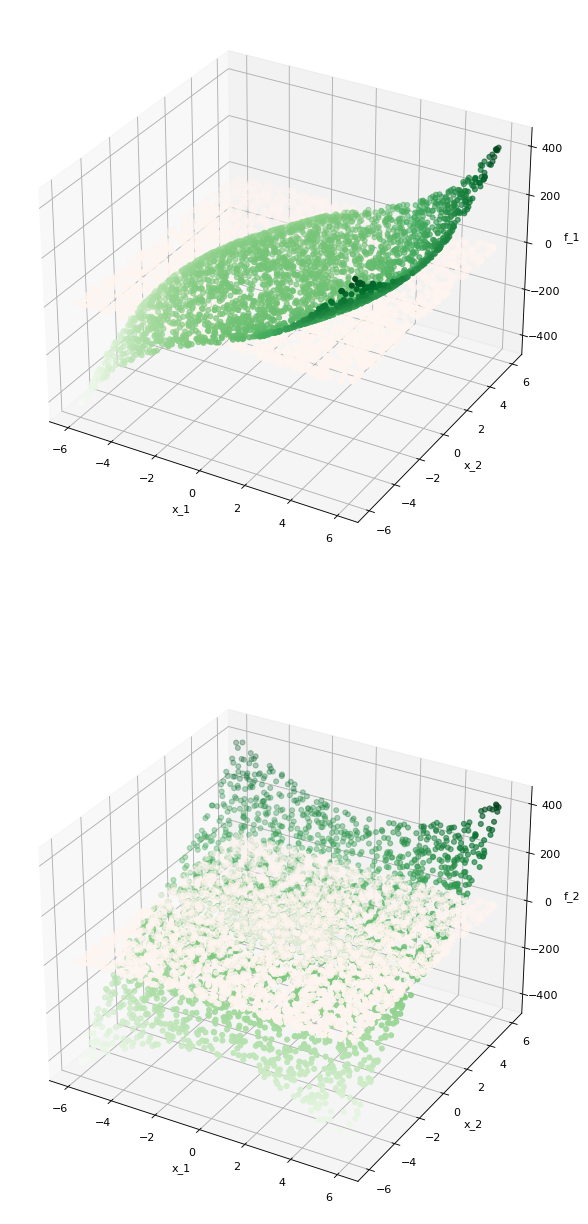

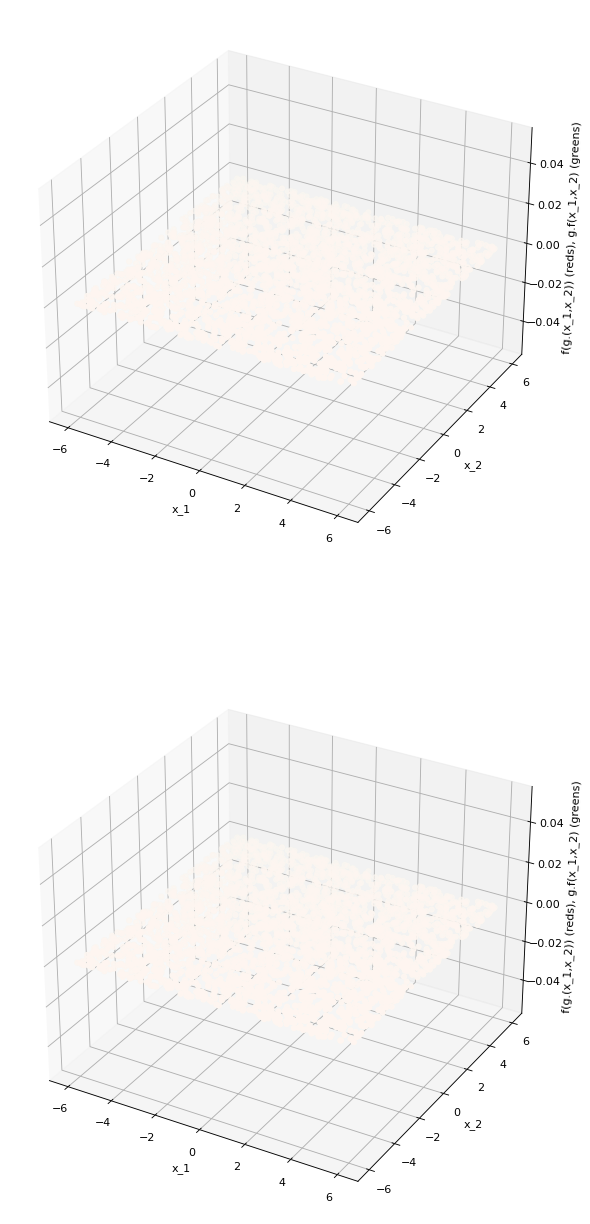

In [165]:
#Plot to compare true value to values from model
fig = plt.figure(figsize=(20, 20), dpi=80)
#Plot graph of f_1(x_1,x_2)
ax = fig.add_subplot(2, 1, 1, projection='3d')
ax.scatter(x_test[:,0],x_test[:,1],y_test[:,0], c=y_test[:,0], cmap='Greens')
ax.scatter(x_test[:,0],x_test[:,1],val_logits[1:,0], c=val_logits[1:,0], cmap='Reds')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('f_1')

#Plot graph of f_2(x_1,x_2)
ax = fig.add_subplot(2, 1, 2, projection='3d')
ax.scatter(x_test[:,0],x_test[:,1],y_test[:,1], c=y_test[:,1], cmap='Greens')
ax.scatter(x_test[:,0],x_test[:,1],val_logits[1:,1], c=val_logits[1:,1], cmap='Reds')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('f_2')

plt.show()



#Plot to show equivariance
fig = plt.figure(figsize=(20, 20), dpi=80)

#Plot graph to show first dim of f(g.(x_1,x_2))= first dim of g.f(x_1,x_2)
#for data predicted by model
ax = fig.add_subplot(2, 1, 1, projection='3d')
ax.scatter(x_test[:,0],x_test[:,1],
           val_logits_normal_aug[1:,0], c=val_logits_normal_aug[1:,0], cmap='Greens')
ax.scatter(x_test[:,0],x_test[:,1],
           val_logits_aug_normal[1:,0], c=val_logits_aug_normal[1:,0], cmap='Reds')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('f(g.(x_1,x_2)) (reds), g.f(x_1,x_2) (greens)')

#Plot graph to show second dim of f(g.(x_1,x_2))= second dim of g.f(x_1,x_2)
#for data predicted by model
ax = fig.add_subplot(2, 1, 2, projection='3d')
ax.scatter(x_test[:,0],x_test[:,1],
           val_logits_normal_aug[1:,1], c=val_logits_normal_aug[1:,1], cmap='Greens')
ax.scatter(x_test[:,0],x_test[:,1],
           val_logits_aug_normal[1:,1], c=val_logits_aug_normal[1:,1], cmap='Reds')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('f(g.(x_1,x_2)) (reds), g.f(x_1,x_2) (greens)')

plt.show()



# #Integrate to make trajectories through (1,1)
# x_init = [1,1]
# t_line = np.linspace(0, 15, 1000)
# #Analytic integration
# x_traj_true = (x_init[0]**2+x_init[1]**2)*x_init*t_line
# #Numerical integration of model function
# x_traj_model = 

# #Plot to compare trajectories
# fig = plt.figure(figsize=(8, 6), dpi=80)
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax.plot3D(x_line, y_line, t_line, 'gray')
# ax.plot3D(x_line, y_line, t_line, 'black')

# plt.show()
